## AttentiveFP: Pushing the Boundaries of Molecular Representation for Drug Discovery with the Graph Attention Mechanism

ABSTRACT: Hunting for chemicals with favorable pharmacological, toxicological, and pharmacokinetic properties
remains a formidable challenge for drug discovery. Deep
learning provides us with powerful tools to build predictive
models that are appropriate for the rising amounts of data, but
the gap between what these neural networks learn and what
human beings can comprehend is growing. Moreover, this gap
may induce distrust and restrict deep learning applications in
practice. Here, we introduce a new graph neural network
architecture called <code>AttentiveFP</code> for molecular representation that uses a graph attention mechanism to learn from relevant drug discovery datasets. We demonstrate that <code>AttentiveFP</code> achieves state-of-the-art predictive performances on a variety of datasets and that what it learns is interpretable. The feature visualization for <code>AttentiveFP</code> suggests that it automatically learns nonlocal intramolecular interactions from specified tasks, which can help us gain chemical insights directly from data beyond human perception.

Link to paper: https://pubs.acs.org/doi/pdf/10.1021/acs.jmedchem.9b00959

Credit: https://github.com/OpenDrugAI/AttentiveFP


In [1]:
# Clone the repository and cd into directory
!git clone https://github.com/saams4u/AttentiveFP.git
%cd AttentiveFP

Cloning into 'AttentiveFP'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 70 (delta 3), reused 7 (delta 2), pack-reused 61
Unpacking objects: 100% (70/70), done.
/content/AttentiveFP


In [2]:
# Install RDKit
!pip install rdkit-pypi==2021.3.1.5

     |████████████████████████████████| 18.0MB 292kB/s 


### Example: Malaria Bioactivity

In [5]:
import os

from IPython.display import SVG, display

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

torch.manual_seed(8)

import time
import numpy as np
import gc
import sys

sys.setrecursionlimit(50000)

import pickle

torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')

# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True

import copy
import pandas as pd

from sklearn.metrics import roc_auc_score, matthews_corrcoef, recall_score, accuracy_score, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, precision_recall_curve
from sklearn.metrics import auc, f1_score

from rdkit import Chem
from rdkit.Chem import AllChem, QED, rdMolDescriptors, MolSurf, rdDepictor
from rdkit.Chem.Draw import SimilarityMaps, rdMolDraw2D

%matplotlib inline

from numpy.polynomial.polynomial import polyfit
from IPython.display import SVG, display

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

import seaborn as sns; sns.set_style("darkgrid")

import sascorer
import itertools
import scipy

import AttentiveLayers, AttentiveLayers_viz
import Featurizer, Featurizer_aromaticity_rm, getFeatures, getFeatures_aromaticity_rm

from getFeatures import save_smiles_dicts, get_smiles_array
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [5]:
task_name = 'Malaria Bioactivity'
tasks = ['Loge EC50']

raw_filename = "data/malaria-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')

smiles_tasks_df = pd.read_csv(raw_filename, names = ["Loge EC50", "smiles"])
smilesList = smiles_tasks_df.smiles.values

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)

print("number of all smiles: ",len(smilesList))

atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []

for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass

print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]

print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] = canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()

plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

feature dicts file saved as data/malaria-processed.pickle
number of all smiles:  9999
number of successfully processed smiles:  9999
      Loge EC50                                             smiles
0      2.708050  COc1ccc(C)c2sc(nc12)N(Cc3cccnc3)C(=O)c4ccc(cc4...
1      2.708050               CC(Sc1ccc(Cl)cc1)C(=O)Nc2ccc(Br)cc2F
2      2.708050  Cc1ccc(cc1)S(=O)(=O)NCC(N2CCN(CC2)c3ccccc3F)c4...
3      2.708050       Cc1ccc2oc(nc2c1)c3cccc(NC(=O)C(Cl)(Cl)Cl)c3C
4      2.708050          FC(F)(F)c1cccc(NC(=O)C2=Cc3ccccc3OC2=O)c1
...         ...                                                ...
9994  -5.880997  CC[C@@]1(CCC(O1)[C@@]2(C)CC[C@@]3(C[C@@H](O)[C...
9995  -6.017809  CC1=CC(=O)OC[C@]23C[C@H](O)C(=C[C@H]2O[C@@H]4C...
9996  -6.019453      CCOC(=O)C(=O)N1c2ccc(OC)cc2C3=C(SSC3=S)C1(C)C
9997  -6.021511                  CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12
9998  -6.921854                   CC1(C)N=C(N)N=C(N)N1c2ccc(Cl)cc2

[9999 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [6]:
random_seed = 68
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 800

p_dropout= 0.03
fingerprint_dim = 200

weight_decay = 4.3 # also known as l2_regularization_lambda
learning_rate = 4
radius = 2
T = 1

per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [7]:
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

,Loge EC50,smiles,cano_smiles


In [8]:
test_df = remained_df.sample(frac=0.2,random_state=random_seed)
train_df = remained_df.drop(test_df.index)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(len(test_df), sorted(test_df.cano_smiles.values))

2000 ['Brc1ccc2ncnc(NCC3CCCO3)c2c1', 'C#CCN(CC=C)Cc1nc(-c2cc(OC)ccc2OC)oc1C', 'C#CCN(Cc1cc2c(O)nc(N)nc2cc1C)c1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1', 'C#CCN(Cc1ccc2nc(N)nc(O)c2c1)c1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1', 'C#CCSc1c(CCCC)cnc2c1c(=O)n(C)c(=O)n2C', 'C#CC[n+]1ccn2c(C)ccc2c1CC', 'C#Cc1cccc(NC(=O)[C@H](CC2CCCCC2)Nc2ccc(C#N)c3ccccc23)c1', 'C(#Cc1ccccc1)CN(Cc1ccccn1)Cc1ccccn1', 'C(=Cc1ccccc1)C=NNc1ccnc2ccccc12', 'C(=NNc1nc2ccccc2[nH]1)c1cccc(Oc2ccccc2)c1', 'C/C(=C\\c1csc(C)n1)[C@@H]1C[C@@H]2O[C@@H]2CCC[C@H](C)C(O)[C@@H](C)C(=O)C(C)(C)[C@@H](O)CC(=O)O1', 'C/C(C=C1Sc2ccc3ccoc3c2N1CCO)=C\\c1sc2ccc3occc3c2[n+]1CCO', 'C/C=C/C(C(=O)NCCCC)N1C(=O)c2cc(NC(C)=O)ccc2NC(=O)[C@@H]1C', 'C/C=C/[C@H]1O[C@@](O)([C@@H](C)C(O)C(C)[C@H]2OC(=O)C(OC)=CC(C)=C[C@@H](C)[C@H](O)C(CC)[C@@H](O)[C@H](C)CC(C)=CC=C[C@@H]2OC)C[C@@H](O[C@H]2C[C@@H](O)[C@H](OC(N)=O)[C@@H](C)O2)[C@@H]1C', 'C/C=C1/C[C@H]2[C@@H](OC)Nc3cc(O)c(OC)cc3C(=O)N2C1', 'C1=C(c2ccc(CN3CCCCC3)cc2)N2CCN=C2c2ccccc21', 'C1=CN(Cc2ccccc2)C=CC1=C1C=N

In [9]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = nn.MSELoss()

model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print(params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

863604
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
mol_GRUCell.weight_ih torch.Size([600, 200])
mol_GRUCell.weight_hh torch.Size([600, 200])
mol_GRUCell.bias_ih torch.Size([600])
mol_GRUCell.bias_hh torch.Size([600])
mol_align.weight torch.Size([1, 400])
mol_align.bias torch.Size([1])
mol_attend.weight torch.Si

In [10]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])

    #shuffle them
    np.random.shuffle(valList)
    batch_list = []

    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
        
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        optimizer.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()

def eval(model, dataset):
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []

    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 

    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
        print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.squeeze().cpu().numpy())

    return np.array(test_MAE_list).mean(), np.array(test_MSE_list).mean()

In [11]:
best_param ={}
best_param["train_epoch"] = 0
best_param["test_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["test_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE = eval(model, train_df)
    test_MAE, test_MSE = eval(model, test_df)

    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE

    if test_MSE < best_param["test_MSE"]:
        best_param["test_epoch"] = epoch
        best_param["test_MSE"] = test_MSE

        if test_MSE < 1.1:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >2) and (epoch - best_param["test_epoch"] >18):        
        break
        
    print(epoch, train_MSE, test_MSE)
    
    train(model, train_df, optimizer, loss_function)

Streaming output truncated to the last 5000 lines.
        [-0.2405],
        [-0.5702],
        [-0.4328],
        [-0.3424],
        [-0.6913],
        [-1.1007],
        [-1.7524],
        [ 0.3732],
        [-0.8988],
        [-0.2757],
        [-2.5649],
        [-0.8163],
        [-1.3173],
        [-0.2572],
        [-1.1371],
        [-1.1295],
        [ 0.0405],
        [-1.0224],
        [-1.3242],
        [-0.7857],
        [-0.7580],
        [-1.0891],
        [-1.9349],
        [-2.6613],
        [ 0.0923],
        [-2.0675],
        [-1.1656],
        [-1.7320],
        [-0.0798],
        [-0.2989],
        [-1.5479],
        [-1.6282],
        [-1.2799],
        [-1.3100],
        [-0.9730],
        [ 0.0658],
        [-1.5036],
        [-0.2392],
        [-1.3781],
        [-2.9009],
        [-2.3212],
        [-0.7003],
        [-0.5294],
        [-0.6178],
        [-1.9307],
        [-1.4975],
        [-2.4591],
        [-2.3054],
        [-1.4007],
        [-2.4074],

In [12]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["test_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_MAE, test_MSE = eval(model, test_df)
print("best epoch:",best_param["test_epoch"],"\n","test MSE:",test_MSE)

     Loge EC50  ...                                        cano_smiles
0     0.184240  ...  COc1ccccc1C1CCN(C2CCC(NC(=O)/C=C/c3cc(C(F)(F)F...
1    -1.077439  ...  CCCN(CCC)CCCOc1ccc(C(=O)c2c(-c3ccc(OCCCN(CCC)C...
2    -0.075931  ...  CCCCCN1CCCN(Cc2cccc(NC(=O)c3ccc(Cl)c(Cl)c3)c2)CC1
3     2.708050  ...         CCc1c(C)nc(-n2nc(C)cc2NC(=O)c2ccccc2I)nc1O
4     0.341593  ...  COc1ccc(CNCCc2cccs2)cc1-c1ccc(OC)c(S(=O)(=O)NC...
..         ...  ...                                                ...
195  -2.477276  ...  O=C(NC1CCN(CC2(c3ccc(Cl)cc3)CCCCC2)CC1)c1cc[nH]n1
196   0.004068  ...  CC(Cc1ccc(NC(=O)c2ccc(CC(C)NCc3ccc(Cl)c(Cl)c3)...
197   2.708050  ...  CCOC(=O)C1C(CN(C)c2ccc(F)cc2)=NC(=O)NC1c1ccc(C...
198  -1.934005  ...  N#Cc1cccc(NC(=O)Nc2ccc(-c3ccc(-c4nc5cc(C(F)(F)...
199  -0.916291  ...           COc1cc2ncnc(NC3CCN(Cc4ccccc4)CC3)c2cc1OC

[200 rows x 3 columns]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 

### Example: Photovoltaic Efficiency

In [ ]:
task_name = 'Photovoltaic efficiency'
tasks = ['PCE']

raw_filename = "data/cep-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')

smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)

atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []

for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass

print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)

plt.tight_layout()
plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

number of all smiles:  29978
number of successfully processed smiles:  29978


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [ ]:
random_seed = 888
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 800

p_dropout= 0.15
fingerprint_dim = 200

weight_decay = 4.5 # also known as l2_regularization_lambda
learning_rate = 3.6
radius = 3
T = 1

per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [ ]:
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

feature dicts file saved as /content/AttentiveFP/data/cep-processed.pickle


,smiles,PCE,cano_smiles


In [ ]:
test_df = remained_df.sample(frac=1/5,random_state=random_seed)
train_df = remained_df.drop(test_df.index)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(len(test_df),sorted(test_df.cano_smiles.values))

5996 ['C1=C(C2=CC=C(c3cccc4c[nH]cc34)[SiH2]2)[SiH2]C(c2ccc[nH]2)=C1', 'C1=C(C2=CC=C(c3nccc4nsnc34)[SiH2]2)CC(c2cccc3cscc23)=C1', 'C1=C(C2=CC=C(c3nccc4nsnc34)[SiH2]2)[SiH2]C(c2scc3[nH]ccc23)=C1', 'C1=C(C2=Cc3[nH]ccc3C2)Cc2ccccc21', 'C1=C(C2=Cc3c(ccc4c3=C[SiH2]C=4)[SiH2]2)Cc2cc[se]c21', 'C1=C(C2=Cc3c(ccc4cscc34)[SiH2]2)[SiH2]c2cc[nH]c21', 'C1=C(c2cc3c(ccc4ccccc43)cn2)[SiH2]c2cccnc21', 'C1=C(c2cc3c4c(ccc3c3ccccc23)=C[SiH2]C=4)Cc2ccncc21', 'C1=C(c2cc3c4c[nH]cc4ccc3c3c[nH]cc23)[SiH2]c2ccc3c(c21)=C[SiH2]C=3', 'C1=C(c2cc3c4c[nH]cc4ccc3c3ccccc23)[SiH2]c2ccc3nsnc3c21', 'C1=C(c2cc3ccccc3c3c[nH]cc23)[SiH2]c2ccoc21', 'C1=C(c2cc3cnccc3c3c[nH]cc23)[SiH2]c2ccc3cscc3c21', 'C1=C(c2cc3ncccc3[se]2)[SiH2]c2ccccc21', 'C1=C(c2cc3ncccc3o2)Cc2ccc3cocc3c21', 'C1=C(c2ccc(-c3ccc[nH]3)cc2)CC(c2scc3cc[nH]c23)=C1', 'C1=C(c2ccc(-c3ccc[nH]3)cn2)CC(c2ccco2)=C1', 'C1=C(c2ccc(-c3cccc4c3=C[SiH2]C=4)nc2)CC(c2cccc3nsnc23)=C1', 'C1=C(c2ccc(-c3cccc4c3=C[SiH2]C=4)nc2)[SiH2]C(c2cccc3cocc23)=C1', 'C1=C(c2ccc(-c3cccc4c[nH]cc34)[

In [ ]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
loss_function = nn.MSELoss()

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

1145405
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
GRUCell.2.weight_ih torch.Size([600, 200])
GRUCell.2.weight_hh torch.Size([600, 200])
GRUCell.2.bias_ih torch.Size([600])
GRUCell.2.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 400])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
attend.2.weight torch.Size([200, 200]

In [ ]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])

    #shuffle them
    np.random.shuffle(valList)
    batch_list = []

    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   

    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        optimizer.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()

def eval(model, dataset):
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []

    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
        print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
        
    return np.array(test_MAE_list).mean(), np.array(test_MSE_list).mean()

In [ ]:
best_param ={}
best_param["train_epoch"] = 0
best_param["test_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["test_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE = eval(model, train_df)
    test_MAE, test_MSE = eval(model, test_df)

    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE
    if test_MSE < best_param["test_MSE"]:
        best_param["test_epoch"] = epoch
        best_param["test_MSE"] = test_MSE
        if test_MSE < 0.9:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >2) and (epoch - best_param["test_epoch"] >18):        
        break
    print(epoch, train_MSE, test_MSE)
    
    train(model, train_df, optimizer, loss_function)

Streaming output truncated to the last 5000 lines.
        [6.5327e-03],
        [9.4773e-03],
        [2.4889e-01],
        [5.8520e-03],
        [1.4389e-01],
        [3.6791e-02],
        [7.3747e+01],
        [1.9169e-01],
        [1.9907e-05],
        [1.0974e-02],
        [3.9780e-03],
        [5.0348e-02],
        [6.9856e-05],
        [6.0729e-02],
        [7.4032e-02],
        [2.8800e-04]], grad_fn=<MseLossBackward>)
                                                 smiles  ...                                        cano_smiles
3600        [nH]1c2cc(ncc2c2c3cocc3c3C=CCc3c12)-c1ccco1  ...      C1=Cc2c(c3[nH]c4cc(-c5ccco5)ncc4c3c3cocc23)C1
3601  c1sc(-c2ccc(nc2)-c2ccc(-c3cccc4c[nH]cc34)c3coc...  ...  c1cc(-c2ccc(-c3ccc(-c4scc5ccoc45)cn3)c3cocc23)...
3602  c1sc(-c2cc3cnc4c5ccccc5sc4c3c3=CCC=c23)c2[nH]c...  ...  C1=c2c(-c3scc4cc[nH]c34)cc3cnc4c5ccccc5sc4c3c2...
3603  C1C=c2c3c(sc4cc(C5=CC=CC5)c5nsnc5c34)c3c4cscc4...  ...  C1=CCC(c2cc3sc4c(c5c(c6ccc7cscc7c64)=CCC=5)c3c...
3604     

In [ ]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["test_epoch"])+'.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()
test_MAE, test_MSE = eval(best_model, test_df)
print("best epoch:",best_param["test_epoch"],"\n","test MSE:",test_MSE)

Streaming output truncated to the last 5000 lines.
        [3.0970e-01],
        [1.3815e-04],
        [6.9379e-02],
        [6.4682e-02],
        [7.3690e+01],
        [5.5596e-01],
        [2.6784e-02],
        [2.9299e-02],
        [2.2962e-03],
        [9.6965e-02],
        [6.4013e-03],
        [4.7466e-02],
        [2.7309e-01],
        [3.4328e-03]], grad_fn=<MseLossBackward>)
                                                 smiles  ...                                        cano_smiles
3600        [nH]1c2cc(ncc2c2c3cocc3c3C=CCc3c12)-c1ccco1  ...      C1=Cc2c(c3[nH]c4cc(-c5ccco5)ncc4c3c3cocc23)C1
3601  c1sc(-c2ccc(nc2)-c2ccc(-c3cccc4c[nH]cc34)c3coc...  ...  c1cc(-c2ccc(-c3ccc(-c4scc5ccoc45)cn3)c3cocc23)...
3602  c1sc(-c2cc3cnc4c5ccccc5sc4c3c3=CCC=c23)c2[nH]c...  ...  C1=c2c(-c3scc4cc[nH]c34)cc3cnc4c5ccccc5sc4c3c2...
3603  C1C=c2c3c(sc4cc(C5=CC=CC5)c5nsnc5c34)c3c4cscc4...  ...  C1=CCC(c2cc3sc4c(c5c(c6ccc7cscc7c64)=CCC=5)c3c...
3604      c1cc2sc3c(oc4cc([se]c34)-c3cccc4=CCC=c34)c2

### Example: Solubility



In [ ]:
task_name = 'solubility'
tasks = ['measured log solubility in mols per litre']

raw_filename = "data/delaney-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')

smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)

atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []

for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass

print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]

print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)

plt.tight_layout()
plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

number of all smiles:  1128
number of successfully processed smiles:  1128
         Compound ID  ...                                             smiles
0          Amigdalin  ...  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1           Fenfuram  ...                             Cc1occc1C(=O)Nc2ccccc2
2             citral  ...                               CC(C)=CCCC(C)=CC(=O)
3             Picene  ...                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4          Thiophene  ...                                            c1ccsc1
...              ...  ...                                                ...
1123       halothane  ...                                   FC(F)(F)C(Cl)Br 
1124          Oxamyl  ...                          CNC(=O)ON=C(SC)C(=O)N(C)C
1125       Thiometon  ...                                  CCSCCSP(=S)(OC)OC
1126  2-Methylbutane  ...                                            CCC(C)C
1127        Stirofos  ...              COP(=O)(OC)OC(=CCl)c1cc(Cl)c(Cl)cc1Cl



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [ ]:
random_seed = 888 # 69，103, 107
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 200

p_dropout= 0.2
fingerprint_dim = 200

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
radius = 2
T = 2

per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [ ]:
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

C
feature dicts file saved as /content/AttentiveFP/data/delaney-processed.pickle


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,cano_smiles
934,Methane,-0.636,0,16.043,0,0,0,0.0,-0.9,C,C


In [ ]:
test_df = remained_df.sample(frac=0.2,random_state=random_seed)
train_df = remained_df.drop(test_df.index)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(len(test_df),sorted(test_df.cano_smiles.values))

225 ['BrCBr', 'Brc1ccc(I)cc1', 'Brc1cccc2ccccc12', 'Brc1ccccc1', 'Brc1ccccc1Br', 'C#CCCC', 'C1CCCCC1', 'C1CCCCCCC1', 'C1CCOC1', 'C=C(C)C', 'C=C(C)C1CC=C(C)C(=O)C1', 'C=C(Cl)CSC(=S)N(CC)CC', 'C=CC(=O)OC', 'C=CC(C)(O)CCC=C(C)C', 'C=CCC1(c2ccccc2)C(=O)NC(=O)NC1=O', 'C=Cc1ccccc1', 'CC(=O)C1(C)CCC2C3C=C(C)C4=CC(=O)CCC4(C)C3CCC21C', 'CC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3CCC21C', 'CC(=O)Nc1ccc(O)cc1', 'CC(=O)OC(C)C', 'CC(=O)OCC(=O)C1(O)C(C)CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC21C', 'CC(=O)OCC(=O)C1(O)C(OC(C)=O)CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC21C', 'CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(=O)CC21C', 'CC(=O)OCC(C)C', 'CC(C)=CC1C(C(=O)OCc2cccc(Oc3ccccc3)c2)C1(C)C', 'CC(C)=CCCC(C)=CC=O', 'CC(C)C(=O)C(C)C', 'CC(C)C(C)C(C)C', 'CC(C)C(Nc1ccc(C(F)(F)F)cc1Cl)C(=O)OC(C#N)c1cccc(Oc2ccccc2)c1', 'CC(C)CBr', 'CC(C)CC(C)C', 'CC(C)CCOC=O', 'CC(C)O', 'CC(C)OC(=O)C(O)(c1ccc(Br)cc1)c1ccc(Br)cc1', 'CC(C)c1ccc(NC(=O)N(C)C)cc1', 'CC(C)c1ccccc1', 'CC(Cl)(Cl)Cl', 'CC(N)=O', 'CC1(C)C(C=C(Cl)C(F)(F)F)C1C(=O)OC(

In [ ]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
loss_function = nn.MSELoss()

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

863604
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
mol_GRUCell.weight_ih torch.Size([600, 200])
mol_GRUCell.weight_hh torch.Size([600, 200])
mol_GRUCell.bias_ih torch.Size([600])
mol_GRUCell.bias_hh torch.Size([600])
mol_align.weight torch.Size([1, 400])
mol_align.bias torch.Size([1])
mol_attend.weight torch.Si

In [ ]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []

    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   

    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        model.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()

def eval(model, dataset):
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []

    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 

    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
        print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.squeeze().cpu().numpy())

    return np.array(test_MAE_list).mean(), np.array(test_MSE_list).mean()

In [ ]:
best_param ={}
best_param["train_epoch"] = 0
best_param["test_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["test_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE = eval(model, train_df)
    test_MAE, test_MSE = eval(model, test_df)

    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE

    if test_MSE < best_param["test_MSE"]:
        best_param["test_epoch"] = epoch
        best_param["test_MSE"] = test_MSE
        if test_MSE < 0.35:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["test_epoch"] >18):        
        break
    print(epoch, train_MSE, test_MSE)
    
    train(model, train_df, optimizer, loss_function)

Streaming output truncated to the last 5000 lines.
        [6.8878e-02],
        [1.2117e-04],
        [6.1625e-02],
        [1.1025e-02],
        [8.2167e-03],
        [3.4613e-01],
        [1.5582e-02],
        [1.2623e-02],
        [2.4261e-01],
        [3.1612e-04],
        [2.3293e+00],
        [2.3700e+00],
        [8.1108e-03],
        [6.9644e-01],
        [1.4063e+00],
        [4.8853e-02],
        [1.2787e-01],
        [4.9951e-01],
        [8.7744e-03],
        [5.0927e-01],
        [1.9355e-01],
        [3.5432e-01],
        [3.4909e-02],
        [1.4570e-02],
        [4.5561e-01],
        [4.6312e-03],
        [1.3948e-01],
        [2.2541e-01],
        [1.9747e-01],
        [1.1778e-03],
        [8.1480e-02],
        [1.5078e-01],
        [4.0593e-04],
        [2.4728e-02],
        [2.4883e-01],
        [1.9224e-03],
        [4.5016e-02],
        [6.4182e-01],
        [3.5148e-03],
        [5.6527e-03],
        [3.5276e-03],
        [2.6184e-02],
        [2.4675e-01],
   

In [ ]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["test_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_MAE, test_MSE = eval(model, test_df)
print("best epoch:",best_param["test_epoch"],"\n","test MSE:",test_MSE)

            Compound ID  ...                        cano_smiles
0       o-Chloroaniline  ...                        Nc1ccccc1Cl
1          hydrobenzoin  ...           OC(c1ccccc1)C(O)c1ccccc1
2        m-Nitroaniline  ...            Nc1cccc([N+](=O)[O-])c1
3     1-Bromonapthalene  ...                   Brc1cccc2ccccc12
4    3,4-Dichlorophenol  ...                  Oc1ccc(Cl)c(Cl)c1
..                  ...  ...                                ...
195         Succinimide  ...                      O=C1CCC(=O)N1
196      Dipropyl ether  ...                            CCCOCCC
197           Equilenin  ...  CC12CCc3c(ccc4cc(O)ccc34)C1CCC2=O
198     1-Chloroheptane  ...                          CCCCCCCCl
199    2-Methy-2-Butene  ...                           CC=C(C)C

[200 rows x 11 columns]
[[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

### Example: Bioactivity BACE

In [97]:
task_name = 'BACE'
tasks = ['Class']
raw_filename = "data/bace.csv"

feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')

smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.mol.values
print("number of all smiles: ",len(smilesList))

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)

atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []

for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass

print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["mol"].isin(remained_smiles)]

print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)

plt.tight_layout()
plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

number of all smiles:  1513
number of successfully processed smiles:  1513
                                                    mol  ... canvasUID
0     O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...  ...         1
1     Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...  ...         2
2     S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...  ...         3
3     S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...  ...         4
4     S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...  ...         5
...                                                 ...  ...       ...
1508          Clc1cc2nc(n(c2cc1)C(CC(=O)NCC1CCOCC1)CC)N  ...      1543
1509          Clc1cc2nc(n(c2cc1)C(CC(=O)NCc1ncccc1)CC)N  ...      1544
1510             Brc1cc(ccc1)C1CC1C=1N=C(N)N(C)C(=O)C=1  ...      1545
1511       O=C1N(C)C(=NC(=C1)C1CC1c1cc(ccc1)-c1ccccc1)N  ...      1546
1512                Clc1cc2nc(n(c2cc1)CCCC(=O)NCC1CC1)N  ...      1547

[1513 rows x 595 columns]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


1471 42


In [98]:
random_seed = 88
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.1
fingerprint_dim = 150

radius = 3
T = 2
weight_decay = 2.9 # also known as l2_regularization_lambda
learning_rate = 3.5

per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [109]:
# smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<151]
# uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>150]

# smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

,mol,CID,Class,Model,pIC50,MW,AlogP,HBA,HBD,RB,HeavyAtomCount,ChiralCenterCount,ChiralCenterCountAllPossible,RingCount,PSA,Estate,MR,Polar,sLi_Key,ssBe_Key,ssssBem_Key,sBH2_Key,ssBH_Key,sssB_Key,ssssBm_Key,sCH3_Key,dCH2_Key,ssCH2_Key,tCH_Key,dsCH_Key,aaCH_Key,sssCH_Key,ddC_Key,tsC_Key,dssC_Key,aasC_Key,aaaC_Key,ssssC_Key,sNH3_Key,sNH2_Key,...,Ring perimeter (RNGPERM),Ring bridge count (RNGBDGE),Molecule cyclized degree (MCD),Ring Fusion density (RFDELTA),Ring complexity index (RCI),Van der Waals surface area (VSA),MR1 (MR1),MR2 (MR2),MR3 (MR3),MR4 (MR4),MR5 (MR5),MR6 (MR6),MR7 (MR7),MR8 (MR8),ALOGP1 (ALOGP1),ALOGP2 (ALOGP2),ALOGP3 (ALOGP3),ALOGP4 (ALOGP4),ALOGP5 (ALOGP5),ALOGP6 (ALOGP6),ALOGP7 (ALOGP7),ALOGP8 (ALOGP8),ALOGP9 (ALOGP9),ALOGP10 (ALOGP10),PEOE1 (PEOE1),PEOE2 (PEOE2),PEOE3 (PEOE3),PEOE4 (PEOE4),PEOE5 (PEOE5),PEOE6 (PEOE6),PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14),canvasUID,cano_smiles
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901,431.56979,4.4014,3,2,5,32,2,2,4,77.239998,67.251999,129.903900,58.397999,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,1,1,1,0,1,...,43,-20,0.687500,-1.818182,0.136364,568.26678,0.000000,0,0,0,0,0,0,568.26678,66.530151,76.617577,75.472099,0.000000,11.161491,0.000000,4.298225,0.0,7.026261,327.16098,10.004236,37.570381,9.441768,0.000000,0.0,53.205711,78.640335,226.855410,107.434910,37.133846,0.000000,7.980170,0.000000,0.000000,1,Cc1ccccc1-c1ccc2nc(N)c(C[C@@H](C)C(=O)N[C@@H]3...
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872,657.81073,2.6412,5,4,16,47,6,6,4,124.580000,115.417000,173.617600,76.254997,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,1,0,1,0,0,...,40,-18,0.468085,-1.636364,0.181818,884.51105,1.780931,0,0,0,0,0,0,882.73010,109.402040,79.742088,140.683590,0.000000,5.292510,11.360349,0.000000,0.0,35.550434,502.48004,28.423664,60.594009,43.034393,0.000000,0.0,73.817162,47.171600,365.676940,174.076750,34.923889,7.980170,24.148668,0.000000,24.663788,2,CCCO[C@H]1C[NH2+][C@@H]([C@@H](O)[C@H](Cc2cc(F...
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970,591.74091,2.5499,4,3,11,42,2,3,5,125.860000,96.585999,160.124210,75.639000,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,1,1,0,0,0,...,60,-30,0.595238,-2.400000,0.000000,716.65753,1.780931,0,0,0,0,0,0,714.87659,75.255295,111.248630,113.075360,20.673861,11.951725,9.749552,4.298225,0.0,0.000000,370.40488,27.870480,17.938335,6.779002,33.175568,0.0,70.365707,47.941147,192.406520,255.752550,23.654478,0.230159,15.879790,0.000000,24.663788,3,CCc1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](O)C...
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970,591.67828,3.1680,4,3,12,40,4,5,3,123.840000,112.751000,144.271190,63.681999,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,1,...,33,-15,0.450000,-1.666667,0.166667,720.43549,1.780931,0,0,0,0,0,0,718.65460,74.147835,71.510376,96.723503,9.751966,61.994183,15.429726,0.000000,0.0,17.775217,373.10269,38.175629,12.853045,51.570648,54.055416,0.0,56.657166,37.954151,194.353040,202.763350,36.498634,0.980913,8.188327,0.000000,26.385181,4,CCOC[C@@H](Oc1cc(C[C@@H]2CS(=O)(=O)C[C@H]([NH2...
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970,629.71283,3.5086,3,3,11,44,2,3,5,116.630000,116.336000,159.634700,74.728996,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,1,1,1,0,0,...,60,-30,0.568182,-2.400000,0.000000,714.41241,1.780931,0,0,0,0,0,0,712.63153,62.561653,111.248630,113.075360,10.921895,68.653397,4.684363,4.298225,0.0,0.000000,338.96890,18.118513,17.938335,6.779002,87.230980,0.0,78.945702,39.361153,179.712880,220.461300,23.654478,0.230159,15.879790,0.000000,26.100143,5,CCc1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](O)C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [110]:
weights = []

for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["mol",task]]
    positive_df = remained_df[remained_df[task] == 1][["mol",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])

test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [105]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())

params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

649206
atom_fc.weight torch.Size([150, 39])
atom_fc.bias torch.Size([150])
neighbor_fc.weight torch.Size([150, 49])
neighbor_fc.bias torch.Size([150])
GRUCell.0.weight_ih torch.Size([450, 150])
GRUCell.0.weight_hh torch.Size([450, 150])
GRUCell.0.bias_ih torch.Size([450])
GRUCell.0.bias_hh torch.Size([450])
GRUCell.1.weight_ih torch.Size([450, 150])
GRUCell.1.weight_hh torch.Size([450, 150])
GRUCell.1.bias_ih torch.Size([450])
GRUCell.1.bias_hh torch.Size([450])
GRUCell.2.weight_ih torch.Size([450, 150])
GRUCell.2.weight_hh torch.Size([450, 150])
GRUCell.2.bias_ih torch.Size([450])
GRUCell.2.bias_hh torch.Size([450])
align.0.weight torch.Size([1, 300])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 300])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 300])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([150, 150])
attend.0.bias torch.Size([150])
attend.1.weight torch.Size([150, 150])
attend.1.bias torch.Size([150])
attend.2.weight torch.Size([150, 150])

In [106]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])

    #shuffle them
    np.random.shuffle(valList)
    batch_list = []

    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   

    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        optimizer.zero_grad()
        loss = 0.0
        
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
            
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []

    for i in range(len(tasks)):
        y_val_list[i] = []
        y_pred_list[i] = []
    
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   

    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()

        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
        
            y_val_list[i].extend(y_val_adjust)
            y_pred_list[i].extend(y_pred_adjust)
                
    eval_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
#     eval_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     eval_precision = [precision_score(y_val_list[i],
#                                      (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
#     eval_recall = [recall_score(y_val_list[i],
#                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_loss #eval_prc, eval_precision, eval_recall,

In [107]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_loss = eval(model, train_df)
    valid_roc, valid_loss = eval(model, valid_df)
    
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.85:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
#         +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
#         +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >18) and (epoch - best_param["loss_epoch"] >28):        
        break
        
    torch.manual_seed(epoch)    
    train(model, train_df, optimizer, loss_function)

EPOCH:	0
train_roc:[0.6808890357762538]
valid_roc:[0.6297535211267605]

EPOCH:	1
train_roc:[0.6611473739293288]
valid_roc:[0.5941901408450705]

EPOCH:	2
train_roc:[0.689534275248561]
valid_roc:[0.626056338028169]

EPOCH:	3
train_roc:[0.692965931311796]
valid_roc:[0.6318661971830986]

EPOCH:	4
train_roc:[0.6968437577460134]
valid_roc:[0.6352112676056337]

EPOCH:	5
train_roc:[0.6997025530860117]
valid_roc:[0.6399647887323944]

EPOCH:	6
train_roc:[0.7071745297309207]
valid_roc:[0.6410211267605633]

EPOCH:	7
train_roc:[0.7117711862072765]
valid_roc:[0.6424295774647888]

EPOCH:	8
train_roc:[0.7192404087140929]
valid_roc:[0.6477112676056339]

EPOCH:	9
train_roc:[0.7290341237709659]
valid_roc:[0.6605633802816901]

EPOCH:	10
train_roc:[0.7398744113029826]
valid_roc:[0.6654929577464789]

EPOCH:	11
train_roc:[0.7403618937453524]
valid_roc:[0.668838028169014]

EPOCH:	12
train_roc:[0.7435814811754662]
valid_roc:[0.6725352112676056]

EPOCH:	13
train_roc:[0.742914979757085]
valid_roc:[0.669894366197

KeyboardInterrupt: ignored

In [52]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_roc, test_losses = eval(model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

best epoch:185
test_roc:[0.8531305903398927]
test_roc_mean: 0.8531305903398927


### Example: Bioactivity HIV

In [ ]:
task_name = 'HIV'
tasks = ['HIV_active']
raw_filename = "data/HIV.csv"

feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')

prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))

atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []

for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
        remained_smiles.append(smiles)
    except:
        print("not successfully processed smiles: ", smiles)
        pass

print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)

plt.tight_layout()
plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

number of all smiles:  41127
number of successfully processed smiles:  41127


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


39650 1477


In [ ]:
random_seed = 8
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 200
epochs = 800
p_dropout = 0.1
fingerprint_dim = 150

radius = 4
T = 2
weight_decay = 3.9 # also known as l2_regularization_lambda
learning_rate = 3

per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [ ]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<101]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

C1CN[Co-4]23(N1)(NCCN2)NCCN3
O=C1O[Cu-5]2(O)(O)(OC1=O)OC(=O)C(=O)O2
CCc1cc[n+]([Mn](SC#N)(SC#N)([n+]2ccc(CC)cc2)([n+]2ccc(CC)cc2)[n+]2ccc(CC)cc2)cc1
O=C1O[Al]23(OC1=O)(OC(=O)C(=O)O2)OC(=O)C(=O)O3
O=C1C[N+]23CC[N+]45CC(=O)O[Ni-4]24(O1)(OC(=O)C3)OC(=O)C5
CC1=[O+][Zr]234([O+]=C(C)C1)([O+]=C(C)CC(C)=[O+]2)([O+]=C(C)CC(C)=[O+]3)[O+]=C(C)CC(C)=[O+]4
O=C1C[N+]23CC[N+]45CC(=O)O[Cu-5]24(O1)(OC(=O)C3)OC(=O)C5
c1ccc2c3c(ccc2c1)O[Fe-4]12(Oc4ccc5ccccc5c4N=[O+]1)(Oc1ccc4ccccc4c1N=[O+]2)[O+]=N3
C[N+]1(C)COC(=S)S[Fe-4]123(SC(=S)OC[N+]2(C)C)SC(=S)OC[N+]3(C)C
c1c[n+]([Ni-4]([n+]2cc[nH]c2)([n+]2cc[nH]c2)([n+]2cc[nH]c2)([n+]2cc[nH]c2)[n+]2cc[nH]c2)c[nH]1
Cl[Pd-4]12([S+]=c3nc[nH]c4[nH]cnc34)([S+]=C3N=CNc4[nH]c[n+]1c43)[S+]=C1N=CNc3[nH]c[n+]2c31
CC1=[O+][Mn]23([O+]=C(C)C1)([O+]=C(C)CC(C)=[O+]2)[O+]=C(C)CC(C)=[O+]3
O=C1C[N+]23CCO[Fe-4]245(O1)OC(=O)C[N+]4(CC3)CC(=O)O5
Cl[Sn](Cl)(C12C3=C4C5=C1[Fe]45321678C2=C1C6C7=C28)C12C3=C4C5=C1[Fe]45321678C2=C1C6C7=C28
Br[Ni-4]12(Br)(NCCN1)NCCN2
C1CN[Ni-4]23(N1)(NCCN2)NCCN

,smiles,activity,HIV_active,cano_smiles
71,C1CN[Co-4]23(N1)(NCCN2)NCCN3,CI,0,C1CN[Co-4]23(N1)(NCCN2)NCCN3
79,O=C1O[Cu-5]2(O)(O)(OC1=O)OC(=O)C(=O)O2,CI,0,O=C1O[Cu-5]2(O)(O)(OC1=O)OC(=O)C(=O)O2
88,CCc1cc[n+]([Mn](SC#N)(SC#N)([n+]2ccc(CC)cc2)([...,CI,0,CCc1cc[n+]([Mn](SC#N)(SC#N)([n+]2ccc(CC)cc2)([...
137,O=C1O[Al]23(OC1=O)(OC(=O)C(=O)O2)OC(=O)C(=O)O3,CI,0,O=C1O[Al]23(OC1=O)(OC(=O)C(=O)O2)OC(=O)C(=O)O3
138,O=C1C[N+]23CC[N+]45CC(=O)O[Ni-4]24(O1)(OC(=O)C...,CI,0,O=C1C[N+]23CC[N+]45CC(=O)O[Ni-4]24(O1)(OC(=O)C...
...,...,...,...,...
40746,CC1OC(OC2C(O)COC(OC3C(C)OC(OC4C(OC(=O)C56CCC(C...,CM,1,CC1OC(OC2C(O)COC(OC3C(C)OC(OC4C(OC(=O)C56CCC(C...
40975,CC(C)CCCC(C)C1CCC2C3CCC4CC(CCC=C(c5cc(Cl)c(OCc...,CI,0,CC(C)CCCC(C)C1CCC2C3CCC4CC(CCC=C(c5cc(Cl)c(OCc...
41000,CC(C)CCCC(C)C1CCC2C3CCC4CC(CCC=C(c5cc(Cl)c(OCc...,CI,0,CC(C)CCCC(C)C1CCC2C3CCC4CC(CCC=C(c5cc(Cl)c(OCc...
41027,CC(C)CCCC(C)C1CCC2C3CCC4CC(CCC=C(c5cc(Cl)c(OCc...,CI,0,CC(C)CCCC(C)C1CCC2C3CCC4CC(CCC=C(c5cc(Cl)c(OCc...


In [ ]:
weights = []

for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])

test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]

model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))
# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)

optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

808057
atom_fc.weight torch.Size([150, 39])
atom_fc.bias torch.Size([150])
neighbor_fc.weight torch.Size([150, 49])
neighbor_fc.bias torch.Size([150])
GRUCell.0.weight_ih torch.Size([450, 150])
GRUCell.0.weight_hh torch.Size([450, 150])
GRUCell.0.bias_ih torch.Size([450])
GRUCell.0.bias_hh torch.Size([450])
GRUCell.1.weight_ih torch.Size([450, 150])
GRUCell.1.weight_hh torch.Size([450, 150])
GRUCell.1.bias_ih torch.Size([450])
GRUCell.1.bias_hh torch.Size([450])
GRUCell.2.weight_ih torch.Size([450, 150])
GRUCell.2.weight_hh torch.Size([450, 150])
GRUCell.2.bias_ih torch.Size([450])
GRUCell.2.bias_hh torch.Size([450])
GRUCell.3.weight_ih torch.Size([450, 150])
GRUCell.3.weight_hh torch.Size([450, 150])
GRUCell.3.bias_ih torch.Size([450])
GRUCell.3.bias_hh torch.Size([450])
align.0.weight torch.Size([1, 300])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 300])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 300])
align.2.bias torch.Size([1])
align.3.weight torch.S

In [ ]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])

    #shuffle them
    np.random.shuffle(valList)
    batch_list = []

    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 

    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        optimizer.zero_grad()
        loss = 0.0

        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
            
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []

    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)  

    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
                
    eval_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
#     eval_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     eval_precision = [precision_score(y_val_list[i],
#                                      (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
#     eval_recall = [recall_score(y_val_list[i],
#                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_loss #eval_prc, eval_precision, eval_recall, 

In [ ]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_loss = eval(model, train_df)
    valid_roc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.80:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
#         +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
#         +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >16) and (epoch - best_param["loss_epoch"] >18):        
        break
        
    train(model, train_df, optimizer, loss_function)

EPOCH:	0
train_roc:[0.3576718002116027]
valid_roc:[0.3844487230459274]

EPOCH:	1
train_roc:[0.7180680257295052]
valid_roc:[0.7143795258495529]

EPOCH:	2
train_roc:[0.7483357766348686]
valid_roc:[0.7364944852202114]

EPOCH:	3
train_roc:[0.7621301951002843]
valid_roc:[0.7399476442129433]

EPOCH:	4
train_roc:[0.7708520926296769]
valid_roc:[0.7506108919692834]

EPOCH:	5
train_roc:[0.7725496963749798]
valid_roc:[0.7460632647317659]

EPOCH:	6
train_roc:[0.7748986160448451]
valid_roc:[0.7795696282828464]

EPOCH:	7
train_roc:[0.7861898572276156]
valid_roc:[0.7749214886555016]

EPOCH:	8
train_roc:[0.7874842756930314]
valid_roc:[0.776330895721746]

EPOCH:	9
train_roc:[0.791599234966536]
valid_roc:[0.7905790853819248]

EPOCH:	10
train_roc:[0.7910599749924081]
valid_roc:[0.7852184245911379]

EPOCH:	11
train_roc:[0.7942709352126133]
valid_roc:[0.7722478590860968]

EPOCH:	12
train_roc:[0.7944213022752153]
valid_roc:[0.7861297369255719]

EPOCH:	13
train_roc:[0.8052723033894257]
valid_roc:[0.785180453

In [ ]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()

test_roc, test_losses = eval(best_model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

best epoch:74
test_roc:[0.8497731663288572]
test_roc_mean: 0.8497731663288572


### Example: Bioactivity MUV

In [ ]:
task_name = 'muv'
tasks = [
    "MUV-466","MUV-548","MUV-600","MUV-644","MUV-652","MUV-689","MUV-692","MUV-712","MUV-713","MUV-733","MUV-737","MUV-810","MUV-832","MUV-846","MUV-852","MUV-858","MUV-859"
]
raw_filename = "data/muv.csv"

feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')

smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))

atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []

for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass

print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]

print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)

plt.tight_layout()
plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

number of all smiles:  93087
number of successfully processed smiles:  93087
       MUV-466  ...                                             smiles
0          NaN  ...    Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C
1          0.0  ...                Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1
2          NaN  ...  COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...
3          NaN  ...  O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...
4          0.0  ...                          NC(=O)NC(Cc1ccccc1)C(=O)O
...        ...  ...                                                ...
93082      NaN  ...                           O=C(NCc1ccccc1Cl)C1CCCO1
93083      NaN  ...        COc1cc(NCCCCCN2C(=O)c3ccccc3C2=O)c2ncccc2c1
93084      NaN  ...                 CCN(CC)c1ccc(/C=C2/C(=O)ON=C2C)cc1
93085      NaN  ...   Cc1cc(=O)oc2cc(OCC(=O)c3ccc4c(c3)NC(=O)CO4)ccc12
93086      NaN  ...           COc1ccc([N+](=O)[O-])cc1NC(=O)c1ccc(C)o1

[93087 rows x 19 columns]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


93087 0


In [ ]:
random_seed = 68
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.2
fingerprint_dim = 250

radius = 3
T = 2
weight_decay = 3.5 # also known as l2_regularization_lambda
learning_rate = 3.7

per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [ ]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<151]
# uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>150]

# smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

feature dicts file saved as /content/AttentiveFP/data/muv.pickle


,MUV-466,MUV-548,MUV-600,MUV-644,MUV-652,MUV-689,MUV-692,MUV-712,MUV-713,MUV-733,MUV-737,MUV-810,MUV-832,MUV-846,MUV-852,MUV-858,MUV-859,mol_id,smiles,cano_smiles
11942,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CID750288,COC(=O)Cn1cnc2cccc3cccc1c32,COC(=O)CN1C=Nc2cccc3cccc1c23
15844,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CID6901636,CNC(=S)N/N=c1\c(=O)c2cccc3cccc1c32,CNC(=S)N/N=C1\C(=O)c2cccc3cccc1c23
17840,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CID5771339,CC(=O)c1ccc2cccc3[nH]c(C)nc1c23,CC(=O)c1ccc2cccc3c2c1N=C(C)N3
23103,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,CID1046667,CCOC(=O)c1cn2nc(N3CCCC3)sc3c(F)c(F)c(F)c(c1=O)c32,CCOC(=O)c1cn2c3c(c(F)c(F)c(F)c3c1=O)SC(N1CCCC1...
23165,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,CID3149395,COc1ccc(-c2nc3cccc4cccc([nH]2)c43)cc1,COc1ccc(C2=Nc3cccc4cccc(c34)N2)cc1
32750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,CID801625,COc1ccccc1-c1nc2cccc3cccc([nH]1)c32,COc1ccccc1C1=Nc2cccc3cccc(c23)N1
39313,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,CID2313925,CC(=O)n1c(=O)c2cccc3cccc(c(=O)n1C(C)=O)c32,CC(=O)N1C(=O)c2cccc3cccc(c23)C(=O)N1C(C)=O
40311,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CID4053114,CC(=O)c1ccc2cccc3c2c1ncn3C,CC(=O)c1ccc2cccc3c2c1N=CN3C
46460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,CID2179252,C=CCn1c(=O)n(/C=C/C)c2cccc3cccc1c32,C=CCN1C(=O)N(/C=C/C)c2cccc3cccc1c23
66186,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,CID703829,O=c1c2ccccc2nc2n1-n1cnnc1-c1ccccc1-2,O=c1c2ccccc2nc2c3ccccc3c3nncn3n12


In [ ]:
weights = []

for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]

    negative_test = negative_df.sample(frac=1/10,random_state=random_seed)
    negative_valid = negative_df.drop(negative_test.index).sample(frac=1/9,random_state=random_seed)
    negative_train = negative_df.drop(negative_test.index).drop(negative_valid.index)
    
    positive_test = positive_df.sample(frac=1/10,random_state=random_seed)
    positive_valid = positive_df.drop(positive_test.index).sample(frac=1/9,random_state=random_seed)
    positive_train = positive_df.drop(positive_test.index).drop(positive_valid.index)
    
    weights.append([(positive_test.shape[0]+negative_test.shape[0])/negative_test.shape[0],\
                    (positive_test.shape[0]+negative_test.shape[0])/positive_test.shape[0]])
    
    train_df_new = pd.concat([negative_train,positive_train])
    valid_df_new = pd.concat([negative_valid,positive_valid])
    test_df_new = pd.concat([negative_test,positive_test])

    if i==0:
        train_df = train_df_new
        test_df = test_df_new
        valid_df = valid_df_new
    else:
        train_df = pd.merge(train_df, train_df_new, on='smiles', how='outer') 
        test_df = pd.merge(test_df, test_df_new, on='smiles', how='outer')
        valid_df = pd.merge(valid_df, valid_df_new, on='smiles', how='outer')

In [ ]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))
# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)

optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())

params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

1790038
atom_fc.weight torch.Size([250, 39])
atom_fc.bias torch.Size([250])
neighbor_fc.weight torch.Size([250, 49])
neighbor_fc.bias torch.Size([250])
GRUCell.0.weight_ih torch.Size([750, 250])
GRUCell.0.weight_hh torch.Size([750, 250])
GRUCell.0.bias_ih torch.Size([750])
GRUCell.0.bias_hh torch.Size([750])
GRUCell.1.weight_ih torch.Size([750, 250])
GRUCell.1.weight_hh torch.Size([750, 250])
GRUCell.1.bias_ih torch.Size([750])
GRUCell.1.bias_hh torch.Size([750])
GRUCell.2.weight_ih torch.Size([750, 250])
GRUCell.2.weight_hh torch.Size([750, 250])
GRUCell.2.bias_ih torch.Size([750])
GRUCell.2.bias_hh torch.Size([750])
align.0.weight torch.Size([1, 500])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 500])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 500])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([250, 250])
attend.0.bias torch.Size([250])
attend.1.weight torch.Size([250, 250])
attend.1.bias torch.Size([250])
attend.2.weight torch.Size([250, 250]

In [ ]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])

    #shuffle them
    np.random.shuffle(valList)
    batch_list = []

    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   

    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        model.zero_grad()

        # Step 4. Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
            
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
        
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []

    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 

    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()

        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)            
    eval_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    eval_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     eval_precision = [precision_score(y_val_list[i],
#                                      (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
#     eval_recall = [recall_score(y_val_list[i],
#                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_prc, eval_loss # eval_precision, eval_recall, 

In [ ]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_prc, train_loss = eval(model, train_df)
    valid_roc, valid_prc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    train_prc_mean = np.array(train_prc).mean()
    valid_prc_mean = np.array(valid_prc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.75:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
        +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
        +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        +"train_prc_mean"+":"+str(train_prc_mean)+'\n'\
        +"valid_prc_mean"+":"+str(valid_prc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >6) and (epoch - best_param["loss_epoch"] >8):        
        break
        
    train(model, train_df, optimizer, loss_function)

EPOCH:	0
train_roc:[0.4967834741693488, 0.19534348972100124, 0.574257180119645, 0.7371480482024044, 0.5888294820396811, 0.43160427508253596, 0.4578627652292951, 0.34963963852079993, 0.4776754088131114, 0.5742790008762882, 0.3999673792569143, 0.542576106487699, 0.5051638480810842, 0.26187485808356037, 0.7088595597909713, 0.5244908491070277, 0.6442557527383883]
valid_roc:[0.6022957461174882, 0.2111111111111111, 0.4718820861678005, 0.721498743431574, 0.7285362026451468, 0.19331960649736904, 0.36344969199178645, 0.5827538247566064, 0.2599594868332208, 0.41069397042093286, 0.5393360618462937, 0.701802418434862, 0.8729508196721311, 0.38192552225249776, 0.7147742818057455, 0.4176843057440072, 0.6912364130434783]
train_roc_mean:0.4982712421364562
valid_roc_mean:0.521482958398356
train_prc_mean:0.00551369328951437
valid_prc_mean:0.004575792850201917

EPOCH:	1
train_roc:[0.5595067324035343, 0.7520508090483286, 0.4631035411527884, 0.8017790342385562, 0.6879922231033764, 0.5348963870703001, 0.6304

In [ ]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()

test_roc, test_prc, test_losses = eval(best_model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
      +"\n"+"test_prc_mean:",str(np.array(test_prc).mean())
     )

best epoch:31
test_roc:[0.7454422687373397, 0.973922902494331, 0.9501133786848073, 0.9748686314827507, 0.9417171037883884, 0.9226721574010524, 0.4396532055669633, 0.789522484932777, 0.8726085977942831, 0.9440273037542662, 0.8051386994088222, 0.9219712525667352, 0.9719945355191256, 0.987511353315168, 0.9997720018239853, 0.9513794663048395, 0.5591032608695652]
test_roc_mean: 0.8677305061438352
test_prc_mean: 0.15666023637334905


### Example: Physical Chemistry FreeSolv

In [8]:
random_seed = 8 # 69, 88
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 200

p_dropout= 0.2
fingerprint_dim = 200

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
output_units_num = 1 # for regression model
radius = 2
T = 2

number of all smiles:  642
number of successfully processed smiles:  642


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


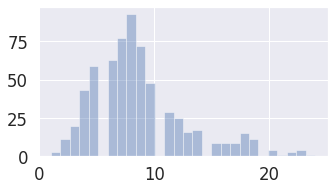

In [10]:
task_name = 'hydration free energy'
tasks = ['expt']

raw_filename = "data/SAMPL.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

In [11]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)

print("not processed items")
uncovered_df

N
S
C
feature dicts file saved as data/SAMPL.pickle
not processed items


,iupac,smiles,expt,calc,cano_smiles
61,ammonia,N,-4.29,-4.018,N
195,hydrogen sulfide,S,-0.70,-1.135,S
286,methane,C,2.00,2.446,C


In [12]:
remained_df = remained_df.reset_index(drop=True)
test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(len(test_df),sorted(test_df.cano_smiles.values))

64 ['C=C(C)CCC', 'C=C(C)[C@@H]1CC=C(C=O)CC1', 'C=C(C)c1ccccc1', 'C=CC=C', 'C=CCCCCCCC', 'C=CCCl', 'CBr', 'CC(=O)CC(C)C', 'CC(C)(C)Br', 'CC(F)F', 'CC1=CCCCC1', 'CC=C(C)C', 'CCC(=O)O', 'CCC(C)(C)O', 'CCCCC#N', 'CCCCC(C)C', 'CCCCC=O', 'CCCCCC(C)=O', 'CCCCCC1CCCC1', 'CCCCCCCC(C)=O', 'CCCCCCCCBr', 'CCCCCCCCCO', 'CCCCCCI', 'CCCCCCl', 'CCCCN(CC)c1c([N+](=O)[O-])cc(C(F)(F)F)cc1[N+](=O)[O-]', 'CCCN(CCC)c1c([N+](=O)[O-])cc(C(F)(F)F)cc1[N+](=O)[O-]', 'CCCSC(=O)N(CCC)CCC', 'CCN(CC)CC', 'CCOCCOCC', 'CCOP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl', 'CCOP(=S)(OCC)SCSCC', 'CCc1cccc(CC)c1N(COC)C(=O)CCl', 'CCc1ccccc1', 'COC(=O)c1ccccc1', 'COC(C)C', 'COC(OC)OC', 'COCCN', 'COP(=O)(OC)[C@@H](O)C(Cl)(Cl)Cl', 'COP(=S)(OC)Oc1ccc([N+](=O)[O-])cc1', 'C[C@H]1CC[C@H](C)O1', 'Cc1[nH]c(=O)n(C(C)(C)C)c(=O)c1Cl', 'Cc1ccc(Br)cc1', 'Cc1ccc(C)c(C)c1', 'Cc1ccc(C)c2ccccc12', 'Cc1ccc(C)cc1', 'Cc1ccccc1C', 'Cc1cncc(C)c1', 'ClCCCCl', 'Clc1ccc2c(c1)Oc1cc(Cl)c(Cl)c(Cl)c1O2', 'Clc1cccc(Cl)c1', 'Clc1cccc(Cl)c1Cl', 'FC(F)(F)F', 'F[C@H](Br)C(F)

In [13]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = nn.MSELoss()

model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

863604
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
mol_GRUCell.weight_ih torch.Size([600, 200])
mol_GRUCell.weight_hh torch.Size([600, 200])
mol_GRUCell.bias_ih torch.Size([600])
mol_GRUCell.bias_hh torch.Size([600])
mol_align.weight torch.Size([1, 400])
mol_align.bias torch.Size([1])
mol_attend.weight torch.Si

In [14]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        model.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(eval_MAE_list).mean(), np.array(eval_MSE_list).mean()

In [15]:
best_param ={}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["valid_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE = eval(model, train_df)
    valid_MAE, valid_MSE = eval(model, valid_df)
#     tensorboard.add_scalars('MAE',{'train_MAE':valid_MAE, 'test_MAE':valid_MSE}, epoch)
#     tensorboard.add_scalars('MSE',{'train_MSE':valid_MAE, 'test_MSE':valid_MSE}, epoch)
    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE
    if valid_MSE < best_param["valid_MSE"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE"] = valid_MSE
        if valid_MSE < 0.8:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >8) and (epoch - best_param["valid_epoch"] >18):        
        break
    print(epoch, np.sqrt(train_MSE), np.sqrt(valid_MSE))
    
    train(model, train_df, optimizer, loss_function)

0 5.4942656 4.634514
1 3.467998 3.4030013
2 3.408371 3.1461716
3 3.326504 3.166823
4 3.2412336 2.9321647
5 3.1026535 2.9105017
6 2.8828008 2.5617304
7 2.5364752 2.341987
8 2.2887704 1.9957032
9 2.0887372 1.8664337
10 1.9893352 1.8874835
11 1.7566099 1.7110602
12 1.752984 1.7150241
13 1.5074893 1.5381532
14 1.4774381 1.4441824
15 1.4825726 1.4988078
16 1.2433466 1.305963
17 1.1938765 1.2192116
18 1.1983697 1.0336355
19 1.1068814 1.1373862
20 1.0694036 1.0751383
21 1.0804449 0.9892739
22 1.0499138 1.0720735
23 1.03669 0.98014414
24 1.0933269 1.1210592
25 1.0017209 1.0107924
26 1.3391122 1.1681077
27 1.3019518 1.2406716
28 1.1290125 1.0643115
29 1.1085218 1.0661922
30 1.0473866 0.97765005
31 1.071292 1.0549964
32 0.9990149 1.0146805
33 0.9755923 0.95965827
34 0.9577579 0.8737185
35 0.9760682 0.9693793
36 0.92782915 0.9387526
37 0.902473 0.922418
38 0.8596943 0.8406642
39 0.80825615 0.7934327
40 0.8017277 0.7811225
41 0.7996109 0.79879105
42 0.8170684 0.7998272
43 0.9232116 0.93503875
44 0

In [16]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()

test_MAE, test_MSE = eval(model, test_df)
print("best epoch:",best_param["valid_epoch"],"\n","test RMSE:",np.sqrt(test_MSE))

best epoch: 65 
 test RMSE: 0.7488723


### Example: Physical Chemistry Lipop

In [17]:
random_seed = 888 # 69, 88
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 200

p_dropout= 0.2
fingerprint_dim = 200

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
output_units_num = 1 # for regression model
radius = 2
T = 4

number of all smiles:  4200
number of successfully processed smiles:  4200


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


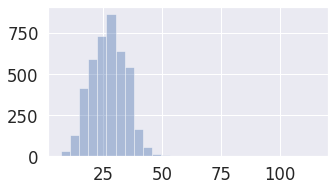

In [18]:
task_name = 'lipophilicity'
tasks = ['exp']

raw_filename = "data/Lipophilicity.csv"
feature_filename = raw_filename.replace('.csv','.pickle')

filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')

smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))

atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []

for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass

print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)

smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)

plt.show()
plt.close()

In [19]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)

print("not processed items")
uncovered_df

feature dicts file saved as data/Lipophilicity.pickle
not processed items


,CMPD_CHEMBLID,exp,smiles,cano_smiles


In [20]:
remained_df = remained_df.reset_index(drop=True)
test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(len(test_df),sorted(test_df.cano_smiles.values))

420 ['C#CCn1c(=O)c2c(-c3nc(C#N)cn3C)n(Cc3ccnc4ccc(Cl)cc34)nc2n(CC2CC2)c1=O', 'C#Cc1cccc(Nc2nc3cc(C(=O)O)ccc3c3cncnc23)c1', 'C(=C/c1c(-c2ccccc2)nc2sccn12)\\c1ccncn1', 'C/N=C(\\S)n1nc(-c2ccc(Cl)cc2)nc1N', 'C=CCC1(CC(C)C)C(=O)NC(=O)NC1=O', 'C=CCOc1ccccc1OCC(O)CNC(C)C', 'C=CCn1c(=O)c2c(-c3cc(C#N)cn3C)n(Cc3ccnc4ccc(Cl)cc34)nc2n(CC2CC2)c1=O', 'CC(=O)N(C)c1ccc(Nc2ncc3cc(-c4ccncc4)ccc3n2)cc1', 'CC(=O)N(C)c1ccccc1', 'CC(=O)N1CCN(CC(O)COc2ccc(Br)cc2)CC1', 'CC(=O)N1CCN(c2nc(C#N)nc(NCC(C)C)c2N)CC1', 'CC(=O)NC(C)c1ccc(Nc2ncc3cc(-c4ccncc4)ccc3n2)cc1', 'CC(=O)NC[C@H]1CN(c2ccc(N3CCN(c4cnccn4)CC3)c(F)c2)C(=O)O1', 'CC(=O)Nc1ccccn1', 'CC(=O)Nc1nc(C)c(-c2cnc(F)c(NS(=O)(=O)c3sc(C)nc3C)c2)s1', 'CC(C)(C#N)c1cnc(N2CCN(C(=O)[C@@H]3CCCC[C@H]3C(=O)NC3(C#N)CC3)CC2)s1', 'CC(C)(C)C(=O)Nc1ccc2c(c1)C(=O)C(=O)c1ccccc1-2', 'CC(C)(C)NC(=O)C(c1ccncc1)N(Cc1ccco1)C(=O)c1ccc(-c2ccccc2)[nH]1', 'CC(C)(C)OC(=O)N1CCN(c2ncc(OCc3c(F)cncc3F)cn2)CC1', 'CC(C)(C)OC(=O)N1CCN(c2ncc(OCc3ccc(S(C)(=O)=O)cc3)cn2)CC1', 'CC(C)(C)OC(=O)N1C[C@

In [21]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = nn.MSELoss()

model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

863604
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
mol_GRUCell.weight_ih torch.Size([600, 200])
mol_GRUCell.weight_hh torch.Size([600, 200])
mol_GRUCell.bias_ih torch.Size([600])
mol_GRUCell.bias_hh torch.Size([600])
mol_align.weight torch.Size([1, 400])
mol_align.bias torch.Size([1])
mol_attend.weight torch.Si

In [22]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        model.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(eval_MAE_list).mean(), np.array(eval_MSE_list).mean()

In [23]:
best_param = {}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["valid_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE = eval(model, train_df)
    valid_MAE, valid_MSE = eval(model, valid_df)
#     tensorboard.add_scalars('MAE',{'train_MAE':valid_MAE, 'test_MAE':valid_MSE}, epoch)
#     tensorboard.add_scalars('MSE',{'train_MSE':valid_MAE, 'test_MSE':valid_MSE}, epoch)
    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE
    if valid_MSE < best_param["valid_MSE"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE"] = valid_MSE
        if valid_MSE < 0.40:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >8) and (epoch - best_param["valid_epoch"] >18):        
        break
    print(epoch, np.sqrt(train_MSE), np.sqrt(valid_MSE))
    
    train(model, train_df, optimizer, loss_function)

0 2.6701732 2.6459734
1 1.1982665 1.2581497
2 1.1416566 1.1672742
3 1.0692173 1.0747727
4 1.1390818 1.1495581
5 1.058199 1.0661169
6 1.0448216 1.0317235
7 0.9282221 0.9049272
8 0.8633561 0.84515727
9 0.8408805 0.81359845
10 0.83607966 0.80161923
11 0.7770222 0.75884104
12 0.7458512 0.74860066
13 0.73009545 0.73551035
14 0.7386357 0.75259507
15 0.7047305 0.71953446
16 0.76889867 0.7953759
17 0.75945103 0.7860525
18 0.7020148 0.71941
19 0.6834683 0.7088833
20 0.6546535 0.6958541
21 0.67527395 0.7091783
22 0.683989 0.7371888
23 0.6220293 0.67991734
24 0.6008408 0.6579603
25 0.67804873 0.72020096
26 0.58447444 0.6501841
27 0.61119896 0.68163633
28 0.5726981 0.65539235
29 0.5689313 0.6574672
30 0.5478039 0.6346673
31 0.5537023 0.6519518
32 0.5288525 0.6265294
33 0.5288563 0.62316793
34 0.5309311 0.64853334
35 0.5134995 0.6130423
36 0.51667666 0.6369984
37 0.5164459 0.65730304
38 0.5280221 0.6515514
39 0.489834 0.6333415
40 0.470644 0.62049675
41 0.48167968 0.642769
42 0.47813508 0.6357203
4

In [24]:
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()

test_MAE, test_MSE = eval(model, test_df)
print("best epoch:",best_param["valid_epoch"],"\n","test RMSE:",np.sqrt(test_MSE))

best epoch: 68 
 test RMSE: 0.5909786


### Example: Physiology or Toxicity BBBP

In [25]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

number of all smiles:  2050
not successfully processed smiles:  O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3
not successfully processed smiles:  c1(nc(NC(N)=[NH2])sc1)CSCCNC(=[NH]C#N)NC
not successfully processed smiles:  Cc1nc(sc1)\[NH]=C(\N)N
not successfully processed smiles:  s1cc(CSCCN\C(NC)=[NH]\C#N)nc1\[NH]=C(\N)N
not successfully processed smiles:  c1c(c(ncc1)CSCCN\C(=[NH]\C#N)NCC)Br
not successfully processed smiles:  n1c(csc1\[NH]=C(\N)N)c1ccccc1
not successfully processed smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N
not successfully processed smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)NC(C)=O
not successfully processed smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N\C(NC)=[NH]\C#N
not successfully processed smiles:  s1cc(nc1\[NH]=C(\N)N)C
not successfully processed smiles:  c1(cc(N\C(=[NH]\c2cccc(c2)CC)C)ccc1)CC
number of successfully processed smiles:  2039


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


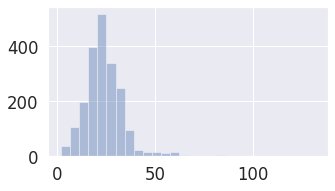

1990 49


In [27]:
task_name = 'BBBP'
tasks = ['BBBP']
raw_filename = "data/BBBP.csv"

feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')

smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))

atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []

for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass

print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]

# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)

plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [34]:
random_seed = 188
random_seed = int(time.time())

start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.1
fingerprint_dim = 150

radius = 3
T = 2

weight_decay = 2.9 # also known as l2_regularization_lambda
learning_rate = 3.5

per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [35]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<101]
uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>100]

smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

,BBBP,smiles,cano_smiles


In [36]:
weights = []

for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])

test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [37]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))
# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)

optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

649206
atom_fc.weight torch.Size([150, 39])
atom_fc.bias torch.Size([150])
neighbor_fc.weight torch.Size([150, 49])
neighbor_fc.bias torch.Size([150])
GRUCell.0.weight_ih torch.Size([450, 150])
GRUCell.0.weight_hh torch.Size([450, 150])
GRUCell.0.bias_ih torch.Size([450])
GRUCell.0.bias_hh torch.Size([450])
GRUCell.1.weight_ih torch.Size([450, 150])
GRUCell.1.weight_hh torch.Size([450, 150])
GRUCell.1.bias_ih torch.Size([450])
GRUCell.1.bias_hh torch.Size([450])
GRUCell.2.weight_ih torch.Size([450, 150])
GRUCell.2.weight_hh torch.Size([450, 150])
GRUCell.2.bias_ih torch.Size([450])
GRUCell.2.bias_hh torch.Size([450])
align.0.weight torch.Size([1, 300])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 300])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 300])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([150, 150])
attend.0.bias torch.Size([150])
attend.1.weight torch.Size([150, 150])
attend.1.bias torch.Size([150])
attend.2.weight torch.Size([150, 150])

In [38]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        model.zero_grad()
        # Step 4. Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)            
    test_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    test_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     test_prc = auc(recall, precision)
    test_precision = [precision_score(y_val_list[i],
                                     (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_recall = [recall_score(y_val_list[i],
                               (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_loss = np.array(losses_list).mean()
    
    return test_roc, test_prc, test_precision, test_recall, test_loss

In [39]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_prc, train_precision, train_recall, train_loss = eval(model, train_df)
    valid_roc, valid_prc, valid_precision, valid_recall, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.87:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
#         +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
#         +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >18) and (epoch - best_param["loss_epoch"] >28):        
        break
        
    train(model, train_df, optimizer, loss_function)

EPOCH:	0
train_roc:[0.40032561851556264]
valid_roc:[0.44670748469324]

EPOCH:	1
train_roc:[0.7798276137270552]
valid_roc:[0.7533424965637886]

EPOCH:	2
train_roc:[0.7932035115722267]
valid_roc:[0.7888291890541047]

EPOCH:	3
train_roc:[0.7944102154828412]
valid_roc:[0.8290641009621392]

EPOCH:	4
train_roc:[0.8038999733971801]
valid_roc:[0.8001999250281144]

EPOCH:	5
train_roc:[0.8044171322160149]
valid_roc:[0.8413095089341496]

EPOCH:	6
train_roc:[0.8138324022346368]
valid_roc:[0.8265650381107085]

EPOCH:	7
train_roc:[0.8185187549880286]
valid_roc:[0.831813070098713]

EPOCH:	8
train_roc:[0.8209811119978718]
valid_roc:[0.8463076346370111]

EPOCH:	9
train_roc:[0.8287619047619047]
valid_roc:[0.8365612895164314]

EPOCH:	10
train_roc:[0.8302005852620379]
valid_roc:[0.8571785580407347]

EPOCH:	11
train_roc:[0.8329949454642193]
valid_roc:[0.86005248031988]

EPOCH:	12
train_roc:[0.8364299015695663]
valid_roc:[0.8675496688741722]

EPOCH:	13
train_roc:[0.8464900239425379]
valid_roc:[0.86517555916

In [41]:
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()

test_roc, test_prc, test_precision, test_recall, test_losses = eval(best_model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

best epoch:161
test_roc:[0.921207264957265]
test_roc_mean: 0.921207264957265


### Example: Physiology or Toxicity ClinTox

number of all smiles:  1484
not successfully processed smiles:  [NH4][Pt]([NH4])(Cl)Cl
not successfully processed smiles:  c1ccc(cc1)n2c(=O)c(c(=O)n2c3ccccc3)CCS(=O)c4ccccc4
not successfully processed smiles:  Cc1cc2c(cc1C)N3C=N2[Co+]456(N7=C8[C@H](C(C7=CC9=N4C(=C(C1=N5[C@@]([C@@H]2N6C(=C8C)[C@@]([C@H]2CC(=O)N)(CCC(=O)NC[C@H](OP(=O)(O[C@@H]2[C@H](O[C@H]3[C@@H]2O)CO)[O-])C)C)([C@@]([C@@H]1CCC(=O)N)(C)CC(=O)N)C)C)[C@@]([C@@H]9CCC(=O)N)(C)CC(=O)N)(C)C)CCC(=O)N)O
not successfully processed smiles:  Cc1cc2c(cc1C)N3C=N2[Co]456(N7=C8[C@H](C(C7=CC9=N4C(=C(C1=N5[C@@]([C@@H]2N6C(=C8C)[C@@]([C@H]2CC(=O)N)(CCC(=O)NC[C@H](OP(=O)(O[C@@H]2[C@H](O[C@H]3[C@@H]2O)CO)O)C)C)([C@@]([C@@H]1CCC(=O)N)(C)CC(=O)N)C)C)[C@@]([C@@H]9CCC(=O)N)(C)CC(=O)N)(C)C)CCC(=O)N)C#N
not successfully processed smiles:  CCCCc1c(=O)n(n(c1=O)c2ccc(cc2)O)c3ccccc3
not successfully processed smiles:  CCCCc1c(=O)n(n(c1=O)c2ccccc2)c3ccccc3
number of successfully processed smiles:  1478


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


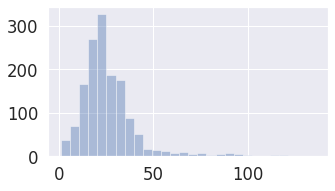

1392 86


In [42]:
task_name = 'clintox'
tasks = [
    'FDA_APPROVED','CT_TOX'
]

raw_filename = "data/clintox.csv"
feature_filename = raw_filename.replace('.csv','.pickle')

filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')

smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))

atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []

for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass

print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]

# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)

plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [43]:
random_seed = 888
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.5
fingerprint_dim = 200

radius = 3
T = 3
weight_decay = 3 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [44]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<151]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

[Se]
N#C[Fe-2](C#N)(C#N)(C#N)(C#N)N=O
feature dicts file saved as data/clintox.pickle


,smiles,FDA_APPROVED,CT_TOX,cano_smiles
12,[Se],0,1,[Se]
20,C(#N)[Fe-2](C#N)(C#N)(C#N)(C#N)N=O,1,0,N#C[Fe-2](C#N)(C#N)(C#N)(C#N)N=O


In [45]:
weights = []

for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])

test_df = remained_df.sample(frac=1/10, random_state=3) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=3) # validation set
train_df = training_data.drop(valid_df.index) # train set

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [46]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))
# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)

optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())

params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

1146008
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
GRUCell.2.weight_ih torch.Size([600, 200])
GRUCell.2.weight_hh torch.Size([600, 200])
GRUCell.2.bias_ih torch.Size([600])
GRUCell.2.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 400])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
attend.2.weight torch.Size([200, 200]

In [47]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        optimizer.zero_grad()
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
                
    eval_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
#     eval_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     eval_precision = [precision_score(y_val_list[i],
#                                      (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
#     eval_recall = [recall_score(y_val_list[i],
#                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_loss #eval_prc, eval_precision, eval_recall,

In [48]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_loss = eval(model, train_df)
    valid_roc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.85:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
        +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
        +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >10) and (epoch - best_param["loss_epoch"] >20):        
        break
        
    train(model, train_df, optimizer, loss_function)

EPOCH:	0
train_roc:[0.3621035140022482, 0.34334352701325177]
valid_roc:[0.37239583333333337, 0.3253255500673552]
train_roc_mean:0.35272352050775
valid_roc_mean:0.3488606917003443

EPOCH:	1
train_roc:[0.6680514148868579, 0.6470948012232416]
valid_roc:[0.6588541666666666, 0.641894925909295]
train_roc_mean:0.6575731080550498
valid_roc_mean:0.6503745462879809

EPOCH:	2
train_roc:[0.7219099750745319, 0.6718297655453619]
valid_roc:[0.6555397727272727, 0.7056578356533452]
train_roc_mean:0.696869870309947
valid_roc_mean:0.6805988041903089

EPOCH:	3
train_roc:[0.7236327647720051, 0.6785830784913354]
valid_roc:[0.6782670454545454, 0.698473282442748]
train_roc_mean:0.7011079216316702
valid_roc_mean:0.6883701639486467

EPOCH:	4
train_roc:[0.7255632667025073, 0.6845158002038737]
valid_roc:[0.6867897727272727, 0.6971261787157611]
train_roc_mean:0.7050395334531905
valid_roc_mean:0.6919579757215168

EPOCH:	5
train_roc:[0.6864156199599237, 0.6455963302752294]
valid_roc:[0.6640625, 0.6993713515940728]
t

In [49]:
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_roc, test_losses = eval(model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

best epoch:64
test_roc:[0.9494252873563219, 0.9340277777777778]
test_roc_mean: 0.9417265325670499


### Example: Physiology or Toxicity SIDER

number of all smiles:  1427
number of successfully processed smiles:  1427


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


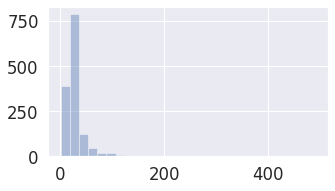

1284 143


In [6]:
task_name = 'sider'
tasks = [
'SIDER1','SIDER2','SIDER3','SIDER4','SIDER5','SIDER6','SIDER7','SIDER8','SIDER9','SIDER10','SIDER11','SIDER12','SIDER13','SIDER14','SIDER15','SIDER16','SIDER17','SIDER18','SIDER19','SIDER20','SIDER21','SIDER22','SIDER23','SIDER24','SIDER25','SIDER26','SIDER27'
]

raw_filename = "data/sider.csv"
feature_filename = raw_filename.replace('.csv','.pickle')

filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')

smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))

atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []

for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass

print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]

# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)

plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [7]:
random_seed = 68
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.5
fingerprint_dim = 200

radius = 3
T = 3
weight_decay = 3 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [8]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<151]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

N
I
[Ca+2]
C
[Cl-]
[K+]
[Mg+2]
[Na+]
[OH-]
FS(F)(F)(F)(F)F
[Ba+2].[H-].[H-]
[H-].[H-].[Sr+2]
[As]
[Se]
[Li+]
[Ra]
[Li+].[OH-]
[I-].[Na+]
[249Cf].[249Cf].[O-2].[O-2].[O-2]
[As+3].[As+3].[O-2].[O-2].[O-2]
F
[Ga+3]
[Fe]
[La]
[Sm]
[Ag]
[Tc]
[Cr]
[Cu]
[Gd]
[Y]
[Zn]
feature dicts file saved as data/sider.pickle


,SIDER1,SIDER2,SIDER3,SIDER4,SIDER5,SIDER6,SIDER7,SIDER8,SIDER9,SIDER10,SIDER11,SIDER12,SIDER13,SIDER14,SIDER15,SIDER16,SIDER17,SIDER18,SIDER19,SIDER20,SIDER21,SIDER22,SIDER23,SIDER24,SIDER25,SIDER26,SIDER27,smiles,cano_smiles
5,0,1,0,1,1,1,1,0,1,0,1,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,1,CC[C@H](C)[C@H]1C(=O)N[C@H]2CSSC[C@@H](C(=O)N[...,CC[C@H](C)[C@H](NC(=O)CN)C(=O)N[C@H](C(=O)N[C@...
29,1,1,0,1,1,1,1,1,1,0,1,1,0,0,1,1,1,0,1,1,1,1,0,1,1,1,1,CC[C@H](C)[C@@H](C(=O)N[C@@H](CCC(=O)O)C(=O)N[...,CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H]...
41,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,N,N
47,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,CC[C@H](C)[C@@H](C(=O)N[C@@H](CC1=CC=C(C=C1)O)...,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...
50,0,0,0,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0,1,1,1,I,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,1,0,0,0,1,1,1,0,1,0,1,1,0,0,1,0,1,0,0,0,1,1,0,0,1,1,0,CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)COP(=...,COCCO[C@H]1[C@@H](O)[C@H](COP(=O)([O-])S[C@H]2...
1392,0,1,0,0,1,1,1,0,1,0,1,1,0,0,1,1,1,0,1,1,1,1,0,1,1,1,1,CCC(C)C(C(=O)NC(CCC(=O)N)C(=O)NC(CC(C)C)C(=O)N...,CCC(C)C(NC(=O)C(CCC(=O)O)NC(=O)C(CO)NC(=O)C(NC...
1393,0,1,0,1,1,1,1,1,1,0,0,1,0,0,1,0,1,0,1,1,1,1,0,1,1,1,1,CC1C(=O)NC(C(=O)NC2CSSCC3C(=O)NC(C(=O)NC(C(=O)...,CSCCC1NC(=O)C(CC(C)C)NC(=O)C(CCCNC(=N)N)NC(=O)...
1396,0,1,0,0,1,1,1,0,1,0,1,1,0,0,1,1,1,0,1,1,1,1,0,0,0,1,1,CC[C@H](C)[C@H]1C(=O)N[C@H](C(=O)NCC(=O)N[C@H]...,CC[C@H](C)[C@@H]1NC(=O)[C@@H]2CSSC[C@H](NC(=O)...


In [10]:
weights = []

for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])

test_df = remained_df.sample(frac=1/10, random_state=3) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=3) # validation set
train_df = training_data.drop(valid_df.index) # train set

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [11]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())

params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

1156058
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
GRUCell.2.weight_ih torch.Size([600, 200])
GRUCell.2.weight_hh torch.Size([600, 200])
GRUCell.2.bias_ih torch.Size([600])
GRUCell.2.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 400])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
attend.2.weight torch.Size([200, 200]

In [12]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        optimizer.zero_grad()
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
        
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
                
    eval_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
#     eval_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     eval_precision = [precision_score(y_val_list[i],
#                                      (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
#     eval_recall = [recall_score(y_val_list[i],
#                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_loss #eval_prc, eval_precision, eval_recall,

In [16]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_loss = eval(model, train_df)
    valid_roc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.52:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
#         +"train_roc"+":"+str(train_roc)+'\n'\
#         +"valid_roc"+":"+str(valid_roc)+'\n'\
        +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
        +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >18) and (epoch - best_param["loss_epoch"] >28):        
        break
        
    train(model, train_df, optimizer, loss_function)

EPOCH:	0
train_roc_mean:0.8807942031120002
valid_roc_mean:0.6086665815645163

EPOCH:	1
train_roc_mean:0.869425960858532
valid_roc_mean:0.6102891724705515

EPOCH:	2
train_roc_mean:0.8777164034181555
valid_roc_mean:0.6198233306776051

EPOCH:	3
train_roc_mean:0.8851060593276623
valid_roc_mean:0.6192912626141079

EPOCH:	4
train_roc_mean:0.8889811001474568
valid_roc_mean:0.5983041025831972

EPOCH:	5
train_roc_mean:0.889699749740705
valid_roc_mean:0.6087960806180396

EPOCH:	6
train_roc_mean:0.889485335677949
valid_roc_mean:0.5973091618536073

EPOCH:	7
train_roc_mean:0.8949171112525933
valid_roc_mean:0.6196209763394004

EPOCH:	8
train_roc_mean:0.888090717379834
valid_roc_mean:0.6301731315334782

EPOCH:	9
train_roc_mean:0.8967069344523403
valid_roc_mean:0.6038358653675145

EPOCH:	10
train_roc_mean:0.8987890393343221
valid_roc_mean:0.6096337633999254

EPOCH:	11
train_roc_mean:0.8970408478659467
valid_roc_mean:0.5945076295062965

EPOCH:	12
train_roc_mean:0.900219382429101
valid_roc_mean:0.602537

In [17]:
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_roc, test_losses = eval(model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

best epoch:41
test_roc:[0.6353496353496353, 0.6206804891015417, 0.4925373134328358, 0.6034408602150538, 0.6448717948717948, 0.5108247422680412, 0.7053333333333334, 0.6624649859943977, 0.6299999999999999, 0.6376811594202899, 0.6927942794279428, 0.7227047146401985, 0.6365211365211365, 0.7154326494201606, 0.5394542772861357, 0.7712560386473429, 0.5700992555831266, 0.5921428571428571, 0.6553905390539054, 0.5264864864864864, 0.5905285190999476, 0.6825828797624939, 0.6955266955266955, 0.5910256410256411, 0.6444281524926687, 0.7693333333333333, 0.5081109366823653]
test_roc_mean: 0.6313704705970133


### Example: Physiology or Toxicity Tox21

number of all smiles:  7831
number of successfully processed smiles:  7831


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


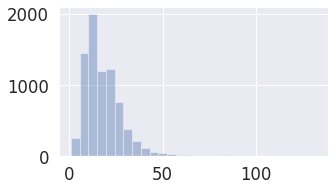

7680 151


In [18]:
task_name = 'tox21'
tasks = [
  'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD',
  'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53'
]

raw_filename = "data/tox21.csv"
feature_filename = raw_filename.replace('.csv','.pickle')

filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')

smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))

atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []

for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass

print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]

# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)

plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [19]:
random_seed = 888
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.5
fingerprint_dim = 200

radius = 3
T = 3
weight_decay = 3 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [20]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

[I-].[K+]
[Hg+2]
[Ba+2]
[TlH2+]
[Cr+3]
[Fe+2]
[Co+2]
[PbH2+2]
[Fe+3]
[Cu+2]
[Cd+2]
[SnH2+2]
[Mn+2]
[Be+2]
[Zn+2]
[Br-].[Na+]
[Ca+2].[Cl-].[Cl-]
[SbH6+3]
[Ni+2]
N#C[Fe-2](C#N)(C#N)(C#N)(C#N)N=O
feature dicts file saved as data/tox21.pickle


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles,cano_smiles
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX14836,[I-].[K+],[I-].[K+]
255,0.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.0,TOX811,[Hg+2],[Hg+2]
659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,TOX131,[Ba+2],[Ba+2]
985,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,TOX4331,[TlH2+],[TlH2+]
1423,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX327,[Cr+3],[Cr+3]
1534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,TOX9688,[Fe+2],[Fe+2]
1722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX340,[Co+2],[Co+2]
1933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX11521,[PbH2+2],[PbH2+2]
2147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX622,[Fe+3],[Fe+3]
2251,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,1.0,NaN,0.0,TOX20449,[Cu+2],[Cu+2]


In [21]:
weights = []

for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])

test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [22]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))
# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)

optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())

params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

1150028
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
GRUCell.2.weight_ih torch.Size([600, 200])
GRUCell.2.weight_hh torch.Size([600, 200])
GRUCell.2.bias_ih torch.Size([600])
GRUCell.2.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 400])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
attend.2.weight torch.Size([200, 200]

In [23]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        optimizer.zero_grad()
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
                
    eval_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
#     eval_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     eval_precision = [precision_score(y_val_list[i],
#                                      (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
#     eval_recall = [recall_score(y_val_list[i],
#                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_loss #eval_prc, eval_precision, eval_recall,

In [24]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_loss = eval(model, train_df)
    valid_roc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.85:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
#         +"train_roc"+":"+str(train_roc)+'\n'\
#         +"valid_roc"+":"+str(valid_roc)+'\n'\
        +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
        +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >10) and (epoch - best_param["loss_epoch"] >20):        
        break
        
    train(model, train_df, optimizer, loss_function)

EPOCH:	0
train_roc_mean:0.4848390572595005
valid_roc_mean:0.5090078324644448

EPOCH:	1
train_roc_mean:0.6800929679902034
valid_roc_mean:0.6871348005898804

EPOCH:	2
train_roc_mean:0.7272696205339325
valid_roc_mean:0.7198875927142824

EPOCH:	3
train_roc_mean:0.7402831901268317
valid_roc_mean:0.7336328216593611

EPOCH:	4
train_roc_mean:0.7483224980987746
valid_roc_mean:0.7387802377971195

EPOCH:	5
train_roc_mean:0.7570870015173549
valid_roc_mean:0.7446790119926194

EPOCH:	6
train_roc_mean:0.7676445890509463
valid_roc_mean:0.7527362395043592

EPOCH:	7
train_roc_mean:0.7813190325203091
valid_roc_mean:0.7585660081384633

EPOCH:	8
train_roc_mean:0.7920052375797106
valid_roc_mean:0.7638764790598213

EPOCH:	9
train_roc_mean:0.7983608750405761
valid_roc_mean:0.7706743956289571

EPOCH:	10
train_roc_mean:0.8102194231888028
valid_roc_mean:0.7807219004787994

EPOCH:	11
train_roc_mean:0.8136559636328267
valid_roc_mean:0.7806301543679953

EPOCH:	12
train_roc_mean:0.8269142855463197
valid_roc_mean:0.7

In [25]:
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_roc, test_losses = eval(model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

best epoch:76
test_roc:[0.8017492711370262, 0.9068962979318466, 0.9044947948560931, 0.8168223119636547, 0.7518498308414275, 0.8522205206738132, 0.8669093851132685, 0.8475032566217977, 0.8584529505582137, 0.7916726852520584, 0.8949438202247191, 0.8675642033542977]
test_roc_mean: 0.8467566107106848


### Example: Physiology or Toxicity ToxCast

number of all smiles:  8597
not successfully processed smiles:  [F-][B+3]([F-])([F-])[F-].CC[N+]1(C)CCCC1
not successfully processed smiles:  [NH4+].[NH4+].[Cl-][Pt++]([Cl-])([Cl-])[Cl-]
not successfully processed smiles:  [Cl-][Pt]1([Cl-])[NH2+]CC[NH2+]1
not successfully processed smiles:  [Na+].[Na+].F[Si--](F)(F)(F)(F)F
not successfully processed smiles:  [NH4+].[NH4+].F[Si--](F)(F)(F)(F)F
not successfully processed smiles:  O.O.O.O.O=C1O[Mg]2(OC(=O)C3=CC=CC=C3O2)OC2=CC=CC=C12
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully proces

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


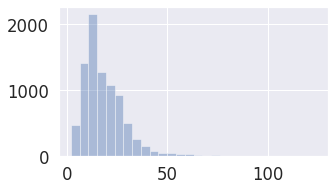

8398 178


In [26]:
task_name = 'toxcast'
tasks = [
'ACEA_T47D_80hr_Negative','ACEA_T47D_80hr_Positive','APR_HepG2_CellCycleArrest_24h_dn','APR_HepG2_CellCycleArrest_24h_up','APR_HepG2_CellCycleArrest_72h_dn','APR_HepG2_CellLoss_24h_dn','APR_HepG2_CellLoss_72h_dn','APR_HepG2_MicrotubuleCSK_24h_dn','APR_HepG2_MicrotubuleCSK_24h_up','APR_HepG2_MicrotubuleCSK_72h_dn','APR_HepG2_MicrotubuleCSK_72h_up','APR_HepG2_MitoMass_24h_dn','APR_HepG2_MitoMass_24h_up','APR_HepG2_MitoMass_72h_dn','APR_HepG2_MitoMass_72h_up','APR_HepG2_MitoMembPot_1h_dn','APR_HepG2_MitoMembPot_24h_dn','APR_HepG2_MitoMembPot_72h_dn','APR_HepG2_MitoticArrest_24h_up','APR_HepG2_MitoticArrest_72h_up','APR_HepG2_NuclearSize_24h_dn','APR_HepG2_NuclearSize_72h_dn','APR_HepG2_NuclearSize_72h_up','APR_HepG2_OxidativeStress_24h_up','APR_HepG2_OxidativeStress_72h_up','APR_HepG2_StressKinase_1h_up','APR_HepG2_StressKinase_24h_up','APR_HepG2_StressKinase_72h_up','APR_HepG2_p53Act_24h_up','APR_HepG2_p53Act_72h_up','APR_Hepat_Apoptosis_24hr_up','APR_Hepat_Apoptosis_48hr_up','APR_Hepat_CellLoss_24hr_dn','APR_Hepat_CellLoss_48hr_dn','APR_Hepat_DNADamage_24hr_up','APR_Hepat_DNADamage_48hr_up','APR_Hepat_DNATexture_24hr_up','APR_Hepat_DNATexture_48hr_up','APR_Hepat_MitoFxnI_1hr_dn','APR_Hepat_MitoFxnI_24hr_dn','APR_Hepat_MitoFxnI_48hr_dn','APR_Hepat_NuclearSize_24hr_dn','APR_Hepat_NuclearSize_48hr_dn','APR_Hepat_Steatosis_24hr_up','APR_Hepat_Steatosis_48hr_up','ATG_AP_1_CIS_dn','ATG_AP_1_CIS_up','ATG_AP_2_CIS_dn','ATG_AP_2_CIS_up','ATG_AR_TRANS_dn','ATG_AR_TRANS_up','ATG_Ahr_CIS_dn','ATG_Ahr_CIS_up','ATG_BRE_CIS_dn','ATG_BRE_CIS_up','ATG_CAR_TRANS_dn','ATG_CAR_TRANS_up','ATG_CMV_CIS_dn','ATG_CMV_CIS_up','ATG_CRE_CIS_dn','ATG_CRE_CIS_up','ATG_C_EBP_CIS_dn','ATG_C_EBP_CIS_up','ATG_DR4_LXR_CIS_dn','ATG_DR4_LXR_CIS_up','ATG_DR5_CIS_dn','ATG_DR5_CIS_up','ATG_E2F_CIS_dn','ATG_E2F_CIS_up','ATG_EGR_CIS_up','ATG_ERE_CIS_dn','ATG_ERE_CIS_up','ATG_ERRa_TRANS_dn','ATG_ERRg_TRANS_dn','ATG_ERRg_TRANS_up','ATG_ERa_TRANS_up','ATG_E_Box_CIS_dn','ATG_E_Box_CIS_up','ATG_Ets_CIS_dn','ATG_Ets_CIS_up','ATG_FXR_TRANS_up','ATG_FoxA2_CIS_dn','ATG_FoxA2_CIS_up','ATG_FoxO_CIS_dn','ATG_FoxO_CIS_up','ATG_GAL4_TRANS_dn','ATG_GATA_CIS_dn','ATG_GATA_CIS_up','ATG_GLI_CIS_dn','ATG_GLI_CIS_up','ATG_GRE_CIS_dn','ATG_GRE_CIS_up','ATG_GR_TRANS_dn','ATG_GR_TRANS_up','ATG_HIF1a_CIS_dn','ATG_HIF1a_CIS_up','ATG_HNF4a_TRANS_dn','ATG_HNF4a_TRANS_up','ATG_HNF6_CIS_dn','ATG_HNF6_CIS_up','ATG_HSE_CIS_dn','ATG_HSE_CIS_up','ATG_IR1_CIS_dn','ATG_IR1_CIS_up','ATG_ISRE_CIS_dn','ATG_ISRE_CIS_up','ATG_LXRa_TRANS_dn','ATG_LXRa_TRANS_up','ATG_LXRb_TRANS_dn','ATG_LXRb_TRANS_up','ATG_MRE_CIS_up','ATG_M_06_TRANS_up','ATG_M_19_CIS_dn','ATG_M_19_TRANS_dn','ATG_M_19_TRANS_up','ATG_M_32_CIS_dn','ATG_M_32_CIS_up','ATG_M_32_TRANS_dn','ATG_M_32_TRANS_up','ATG_M_61_TRANS_up','ATG_Myb_CIS_dn','ATG_Myb_CIS_up','ATG_Myc_CIS_dn','ATG_Myc_CIS_up','ATG_NFI_CIS_dn','ATG_NFI_CIS_up','ATG_NF_kB_CIS_dn','ATG_NF_kB_CIS_up','ATG_NRF1_CIS_dn','ATG_NRF1_CIS_up','ATG_NRF2_ARE_CIS_dn','ATG_NRF2_ARE_CIS_up','ATG_NURR1_TRANS_dn','ATG_NURR1_TRANS_up','ATG_Oct_MLP_CIS_dn','ATG_Oct_MLP_CIS_up','ATG_PBREM_CIS_dn','ATG_PBREM_CIS_up','ATG_PPARa_TRANS_dn','ATG_PPARa_TRANS_up','ATG_PPARd_TRANS_up','ATG_PPARg_TRANS_up','ATG_PPRE_CIS_dn','ATG_PPRE_CIS_up','ATG_PXRE_CIS_dn','ATG_PXRE_CIS_up','ATG_PXR_TRANS_dn','ATG_PXR_TRANS_up','ATG_Pax6_CIS_up','ATG_RARa_TRANS_dn','ATG_RARa_TRANS_up','ATG_RARb_TRANS_dn','ATG_RARb_TRANS_up','ATG_RARg_TRANS_dn','ATG_RARg_TRANS_up','ATG_RORE_CIS_dn','ATG_RORE_CIS_up','ATG_RORb_TRANS_dn','ATG_RORg_TRANS_dn','ATG_RORg_TRANS_up','ATG_RXRa_TRANS_dn','ATG_RXRa_TRANS_up','ATG_RXRb_TRANS_dn','ATG_RXRb_TRANS_up','ATG_SREBP_CIS_dn','ATG_SREBP_CIS_up','ATG_STAT3_CIS_dn','ATG_STAT3_CIS_up','ATG_Sox_CIS_dn','ATG_Sox_CIS_up','ATG_Sp1_CIS_dn','ATG_Sp1_CIS_up','ATG_TAL_CIS_dn','ATG_TAL_CIS_up','ATG_TA_CIS_dn','ATG_TA_CIS_up','ATG_TCF_b_cat_CIS_dn','ATG_TCF_b_cat_CIS_up','ATG_TGFb_CIS_dn','ATG_TGFb_CIS_up','ATG_THRa1_TRANS_dn','ATG_THRa1_TRANS_up','ATG_VDRE_CIS_dn','ATG_VDRE_CIS_up','ATG_VDR_TRANS_dn','ATG_VDR_TRANS_up','ATG_XTT_Cytotoxicity_up','ATG_Xbp1_CIS_dn','ATG_Xbp1_CIS_up','ATG_p53_CIS_dn','ATG_p53_CIS_up','BSK_3C_Eselectin_down','BSK_3C_HLADR_down','BSK_3C_ICAM1_down','BSK_3C_IL8_down','BSK_3C_MCP1_down','BSK_3C_MIG_down','BSK_3C_Proliferation_down','BSK_3C_SRB_down','BSK_3C_Thrombomodulin_down','BSK_3C_Thrombomodulin_up','BSK_3C_TissueFactor_down','BSK_3C_TissueFactor_up','BSK_3C_VCAM1_down','BSK_3C_Vis_down','BSK_3C_uPAR_down','BSK_4H_Eotaxin3_down','BSK_4H_MCP1_down','BSK_4H_Pselectin_down','BSK_4H_Pselectin_up','BSK_4H_SRB_down','BSK_4H_VCAM1_down','BSK_4H_VEGFRII_down','BSK_4H_uPAR_down','BSK_4H_uPAR_up','BSK_BE3C_HLADR_down','BSK_BE3C_IL1a_down','BSK_BE3C_IP10_down','BSK_BE3C_MIG_down','BSK_BE3C_MMP1_down','BSK_BE3C_MMP1_up','BSK_BE3C_PAI1_down','BSK_BE3C_SRB_down','BSK_BE3C_TGFb1_down','BSK_BE3C_tPA_down','BSK_BE3C_uPAR_down','BSK_BE3C_uPAR_up','BSK_BE3C_uPA_down','BSK_CASM3C_HLADR_down','BSK_CASM3C_IL6_down','BSK_CASM3C_IL6_up','BSK_CASM3C_IL8_down','BSK_CASM3C_LDLR_down','BSK_CASM3C_LDLR_up','BSK_CASM3C_MCP1_down','BSK_CASM3C_MCP1_up','BSK_CASM3C_MCSF_down','BSK_CASM3C_MCSF_up','BSK_CASM3C_MIG_down','BSK_CASM3C_Proliferation_down','BSK_CASM3C_Proliferation_up','BSK_CASM3C_SAA_down','BSK_CASM3C_SAA_up','BSK_CASM3C_SRB_down','BSK_CASM3C_Thrombomodulin_down','BSK_CASM3C_Thrombomodulin_up','BSK_CASM3C_TissueFactor_down','BSK_CASM3C_VCAM1_down','BSK_CASM3C_VCAM1_up','BSK_CASM3C_uPAR_down','BSK_CASM3C_uPAR_up','BSK_KF3CT_ICAM1_down','BSK_KF3CT_IL1a_down','BSK_KF3CT_IP10_down','BSK_KF3CT_IP10_up','BSK_KF3CT_MCP1_down','BSK_KF3CT_MCP1_up','BSK_KF3CT_MMP9_down','BSK_KF3CT_SRB_down','BSK_KF3CT_TGFb1_down','BSK_KF3CT_TIMP2_down','BSK_KF3CT_uPA_down','BSK_LPS_CD40_down','BSK_LPS_Eselectin_down','BSK_LPS_Eselectin_up','BSK_LPS_IL1a_down','BSK_LPS_IL1a_up','BSK_LPS_IL8_down','BSK_LPS_IL8_up','BSK_LPS_MCP1_down','BSK_LPS_MCSF_down','BSK_LPS_PGE2_down','BSK_LPS_PGE2_up','BSK_LPS_SRB_down','BSK_LPS_TNFa_down','BSK_LPS_TNFa_up','BSK_LPS_TissueFactor_down','BSK_LPS_TissueFactor_up','BSK_LPS_VCAM1_down','BSK_SAg_CD38_down','BSK_SAg_CD40_down','BSK_SAg_CD69_down','BSK_SAg_Eselectin_down','BSK_SAg_Eselectin_up','BSK_SAg_IL8_down','BSK_SAg_IL8_up','BSK_SAg_MCP1_down','BSK_SAg_MIG_down','BSK_SAg_PBMCCytotoxicity_down','BSK_SAg_PBMCCytotoxicity_up','BSK_SAg_Proliferation_down','BSK_SAg_SRB_down','BSK_hDFCGF_CollagenIII_down','BSK_hDFCGF_EGFR_down','BSK_hDFCGF_EGFR_up','BSK_hDFCGF_IL8_down','BSK_hDFCGF_IP10_down','BSK_hDFCGF_MCSF_down','BSK_hDFCGF_MIG_down','BSK_hDFCGF_MMP1_down','BSK_hDFCGF_MMP1_up','BSK_hDFCGF_PAI1_down','BSK_hDFCGF_Proliferation_down','BSK_hDFCGF_SRB_down','BSK_hDFCGF_TIMP1_down','BSK_hDFCGF_VCAM1_down','CEETOX_H295R_11DCORT_dn','CEETOX_H295R_ANDR_dn','CEETOX_H295R_CORTISOL_dn','CEETOX_H295R_DOC_dn','CEETOX_H295R_DOC_up','CEETOX_H295R_ESTRADIOL_dn','CEETOX_H295R_ESTRADIOL_up','CEETOX_H295R_ESTRONE_dn','CEETOX_H295R_ESTRONE_up','CEETOX_H295R_OHPREG_up','CEETOX_H295R_OHPROG_dn','CEETOX_H295R_OHPROG_up','CEETOX_H295R_PROG_up','CEETOX_H295R_TESTO_dn','CLD_ABCB1_48hr','CLD_ABCG2_48hr','CLD_CYP1A1_24hr','CLD_CYP1A1_48hr','CLD_CYP1A1_6hr','CLD_CYP1A2_24hr','CLD_CYP1A2_48hr','CLD_CYP1A2_6hr','CLD_CYP2B6_24hr','CLD_CYP2B6_48hr','CLD_CYP2B6_6hr','CLD_CYP3A4_24hr','CLD_CYP3A4_48hr','CLD_CYP3A4_6hr','CLD_GSTA2_48hr','CLD_SULT2A_24hr','CLD_SULT2A_48hr','CLD_UGT1A1_24hr','CLD_UGT1A1_48hr','NCCT_HEK293T_CellTiterGLO','NCCT_QuantiLum_inhib_2_dn','NCCT_QuantiLum_inhib_dn','NCCT_TPO_AUR_dn','NCCT_TPO_GUA_dn','NHEERL_ZF_144hpf_TERATOSCORE_up','NVS_ADME_hCYP19A1','NVS_ADME_hCYP1A1','NVS_ADME_hCYP1A2','NVS_ADME_hCYP2A6','NVS_ADME_hCYP2B6','NVS_ADME_hCYP2C19','NVS_ADME_hCYP2C9','NVS_ADME_hCYP2D6','NVS_ADME_hCYP3A4','NVS_ADME_hCYP4F12','NVS_ADME_rCYP2C12','NVS_ENZ_hAChE','NVS_ENZ_hAMPKa1','NVS_ENZ_hAurA','NVS_ENZ_hBACE','NVS_ENZ_hCASP5','NVS_ENZ_hCK1D','NVS_ENZ_hDUSP3','NVS_ENZ_hES','NVS_ENZ_hElastase','NVS_ENZ_hFGFR1','NVS_ENZ_hGSK3b','NVS_ENZ_hMMP1','NVS_ENZ_hMMP13','NVS_ENZ_hMMP2','NVS_ENZ_hMMP3','NVS_ENZ_hMMP7','NVS_ENZ_hMMP9','NVS_ENZ_hPDE10','NVS_ENZ_hPDE4A1','NVS_ENZ_hPDE5','NVS_ENZ_hPI3Ka','NVS_ENZ_hPTEN','NVS_ENZ_hPTPN11','NVS_ENZ_hPTPN12','NVS_ENZ_hPTPN13','NVS_ENZ_hPTPN9','NVS_ENZ_hPTPRC','NVS_ENZ_hSIRT1','NVS_ENZ_hSIRT2','NVS_ENZ_hTrkA','NVS_ENZ_hVEGFR2','NVS_ENZ_oCOX1','NVS_ENZ_oCOX2','NVS_ENZ_rAChE','NVS_ENZ_rCNOS','NVS_ENZ_rMAOAC','NVS_ENZ_rMAOAP','NVS_ENZ_rMAOBC','NVS_ENZ_rMAOBP','NVS_ENZ_rabI2C','NVS_GPCR_bAdoR_NonSelective','NVS_GPCR_bDR_NonSelective','NVS_GPCR_g5HT4','NVS_GPCR_gH2','NVS_GPCR_gLTB4','NVS_GPCR_gLTD4','NVS_GPCR_gMPeripheral_NonSelective','NVS_GPCR_gOpiateK','NVS_GPCR_h5HT2A','NVS_GPCR_h5HT5A','NVS_GPCR_h5HT6','NVS_GPCR_h5HT7','NVS_GPCR_hAT1','NVS_GPCR_hAdoRA1','NVS_GPCR_hAdoRA2a','NVS_GPCR_hAdra2A','NVS_GPCR_hAdra2C','NVS_GPCR_hAdrb1','NVS_GPCR_hAdrb2','NVS_GPCR_hAdrb3','NVS_GPCR_hDRD1','NVS_GPCR_hDRD2s','NVS_GPCR_hDRD4.4','NVS_GPCR_hH1','NVS_GPCR_hLTB4_BLT1','NVS_GPCR_hM1','NVS_GPCR_hM2','NVS_GPCR_hM3','NVS_GPCR_hM4','NVS_GPCR_hNK2','NVS_GPCR_hOpiate_D1','NVS_GPCR_hOpiate_mu','NVS_GPCR_hTXA2','NVS_GPCR_p5HT2C','NVS_GPCR_r5HT1_NonSelective','NVS_GPCR_r5HT_NonSelective','NVS_GPCR_rAdra1B','NVS_GPCR_rAdra1_NonSelective','NVS_GPCR_rAdra2_NonSelective','NVS_GPCR_rAdrb_NonSelective','NVS_GPCR_rNK1','NVS_GPCR_rNK3','NVS_GPCR_rOpiate_NonSelective','NVS_GPCR_rOpiate_NonSelectiveNa','NVS_GPCR_rSST','NVS_GPCR_rTRH','NVS_GPCR_rV1','NVS_GPCR_rabPAF','NVS_GPCR_rmAdra2B','NVS_IC_hKhERGCh','NVS_IC_rCaBTZCHL','NVS_IC_rCaDHPRCh_L','NVS_IC_rNaCh_site2','NVS_LGIC_bGABARa1','NVS_LGIC_h5HT3','NVS_LGIC_hNNR_NBungSens','NVS_LGIC_rGABAR_NonSelective','NVS_LGIC_rNNR_BungSens','NVS_MP_hPBR','NVS_MP_rPBR','NVS_NR_bER','NVS_NR_bPR','NVS_NR_cAR','NVS_NR_hAR','NVS_NR_hCAR_Antagonist','NVS_NR_hER','NVS_NR_hFXR_Agonist','NVS_NR_hFXR_Antagonist','NVS_NR_hGR','NVS_NR_hPPARa','NVS_NR_hPPARg','NVS_NR_hPR','NVS_NR_hPXR','NVS_NR_hRAR_Antagonist','NVS_NR_hRARa_Agonist','NVS_NR_hTRa_Antagonist','NVS_NR_mERa','NVS_NR_rAR','NVS_NR_rMR','NVS_OR_gSIGMA_NonSelective','NVS_TR_gDAT','NVS_TR_hAdoT','NVS_TR_hDAT','NVS_TR_hNET','NVS_TR_hSERT','NVS_TR_rNET','NVS_TR_rSERT','NVS_TR_rVMAT2','OT_AR_ARELUC_AG_1440','OT_AR_ARSRC1_0480','OT_AR_ARSRC1_0960','OT_ER_ERaERa_0480','OT_ER_ERaERa_1440','OT_ER_ERaERb_0480','OT_ER_ERaERb_1440','OT_ER_ERbERb_0480','OT_ER_ERbERb_1440','OT_ERa_EREGFP_0120','OT_ERa_EREGFP_0480','OT_FXR_FXRSRC1_0480','OT_FXR_FXRSRC1_1440','OT_NURR1_NURR1RXRa_0480','OT_NURR1_NURR1RXRa_1440','TOX21_ARE_BLA_Agonist_ch1','TOX21_ARE_BLA_Agonist_ch2','TOX21_ARE_BLA_agonist_ratio','TOX21_ARE_BLA_agonist_viability','TOX21_AR_BLA_Agonist_ch1','TOX21_AR_BLA_Agonist_ch2','TOX21_AR_BLA_Agonist_ratio','TOX21_AR_BLA_Antagonist_ch1','TOX21_AR_BLA_Antagonist_ch2','TOX21_AR_BLA_Antagonist_ratio','TOX21_AR_BLA_Antagonist_viability','TOX21_AR_LUC_MDAKB2_Agonist','TOX21_AR_LUC_MDAKB2_Antagonist','TOX21_AR_LUC_MDAKB2_Antagonist2','TOX21_AhR_LUC_Agonist','TOX21_Aromatase_Inhibition','TOX21_AutoFluor_HEK293_Cell_blue','TOX21_AutoFluor_HEK293_Media_blue','TOX21_AutoFluor_HEPG2_Cell_blue','TOX21_AutoFluor_HEPG2_Cell_green','TOX21_AutoFluor_HEPG2_Media_blue','TOX21_AutoFluor_HEPG2_Media_green','TOX21_ELG1_LUC_Agonist','TOX21_ERa_BLA_Agonist_ch1','TOX21_ERa_BLA_Agonist_ch2','TOX21_ERa_BLA_Agonist_ratio','TOX21_ERa_BLA_Antagonist_ch1','TOX21_ERa_BLA_Antagonist_ch2','TOX21_ERa_BLA_Antagonist_ratio','TOX21_ERa_BLA_Antagonist_viability','TOX21_ERa_LUC_BG1_Agonist','TOX21_ERa_LUC_BG1_Antagonist','TOX21_ESRE_BLA_ch1','TOX21_ESRE_BLA_ch2','TOX21_ESRE_BLA_ratio','TOX21_ESRE_BLA_viability','TOX21_FXR_BLA_Antagonist_ch1','TOX21_FXR_BLA_Antagonist_ch2','TOX21_FXR_BLA_agonist_ch2','TOX21_FXR_BLA_agonist_ratio','TOX21_FXR_BLA_antagonist_ratio','TOX21_FXR_BLA_antagonist_viability','TOX21_GR_BLA_Agonist_ch1','TOX21_GR_BLA_Agonist_ch2','TOX21_GR_BLA_Agonist_ratio','TOX21_GR_BLA_Antagonist_ch2','TOX21_GR_BLA_Antagonist_ratio','TOX21_GR_BLA_Antagonist_viability','TOX21_HSE_BLA_agonist_ch1','TOX21_HSE_BLA_agonist_ch2','TOX21_HSE_BLA_agonist_ratio','TOX21_HSE_BLA_agonist_viability','TOX21_MMP_ratio_down','TOX21_MMP_ratio_up','TOX21_MMP_viability','TOX21_NFkB_BLA_agonist_ch1','TOX21_NFkB_BLA_agonist_ch2','TOX21_NFkB_BLA_agonist_ratio','TOX21_NFkB_BLA_agonist_viability','TOX21_PPARd_BLA_Agonist_viability','TOX21_PPARd_BLA_Antagonist_ch1','TOX21_PPARd_BLA_agonist_ch1','TOX21_PPARd_BLA_agonist_ch2','TOX21_PPARd_BLA_agonist_ratio','TOX21_PPARd_BLA_antagonist_ratio','TOX21_PPARd_BLA_antagonist_viability','TOX21_PPARg_BLA_Agonist_ch1','TOX21_PPARg_BLA_Agonist_ch2','TOX21_PPARg_BLA_Agonist_ratio','TOX21_PPARg_BLA_Antagonist_ch1','TOX21_PPARg_BLA_antagonist_ratio','TOX21_PPARg_BLA_antagonist_viability','TOX21_TR_LUC_GH3_Agonist','TOX21_TR_LUC_GH3_Antagonist','TOX21_VDR_BLA_Agonist_viability','TOX21_VDR_BLA_Antagonist_ch1','TOX21_VDR_BLA_agonist_ch2','TOX21_VDR_BLA_agonist_ratio','TOX21_VDR_BLA_antagonist_ratio','TOX21_VDR_BLA_antagonist_viability','TOX21_p53_BLA_p1_ch1','TOX21_p53_BLA_p1_ch2','TOX21_p53_BLA_p1_ratio','TOX21_p53_BLA_p1_viability','TOX21_p53_BLA_p2_ch1','TOX21_p53_BLA_p2_ch2','TOX21_p53_BLA_p2_ratio','TOX21_p53_BLA_p2_viability','TOX21_p53_BLA_p3_ch1','TOX21_p53_BLA_p3_ch2','TOX21_p53_BLA_p3_ratio','TOX21_p53_BLA_p3_viability','TOX21_p53_BLA_p4_ch1','TOX21_p53_BLA_p4_ch2','TOX21_p53_BLA_p4_ratio','TOX21_p53_BLA_p4_viability','TOX21_p53_BLA_p5_ch1','TOX21_p53_BLA_p5_ch2','TOX21_p53_BLA_p5_ratio','TOX21_p53_BLA_p5_viability','Tanguay_ZF_120hpf_AXIS_up','Tanguay_ZF_120hpf_ActivityScore','Tanguay_ZF_120hpf_BRAI_up','Tanguay_ZF_120hpf_CFIN_up','Tanguay_ZF_120hpf_CIRC_up','Tanguay_ZF_120hpf_EYE_up','Tanguay_ZF_120hpf_JAW_up','Tanguay_ZF_120hpf_MORT_up','Tanguay_ZF_120hpf_OTIC_up','Tanguay_ZF_120hpf_PE_up','Tanguay_ZF_120hpf_PFIN_up','Tanguay_ZF_120hpf_PIG_up','Tanguay_ZF_120hpf_SNOU_up','Tanguay_ZF_120hpf_SOMI_up','Tanguay_ZF_120hpf_SWIM_up','Tanguay_ZF_120hpf_TRUN_up','Tanguay_ZF_120hpf_TR_up','Tanguay_ZF_120hpf_YSE_up'
]

raw_filename = "data/toxcast_data.csv"
feature_filename = raw_filename.replace('.csv','.pickle')

filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')

smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))

atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []

for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass

print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]

# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [27]:
random_seed = 888
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.5
fingerprint_dim = 200

radius = 3
T = 3
weight_decay = 3 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [28]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<151]
uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>150]

smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

[Ca+2].[Cl-].[Cl-]
[Cd+2].[Cl-].[Cl-]
CC[n+]1ccccc1.F[P-](F)(F)(F)(F)F
O.O.[Ba+2].[Cl-].[Cl-]
CC[N+]1(C)CCCC1.F[P-](F)(F)(F)(F)F
N#C[Fe-2](C#N)(C#N)(C#N)(C#N)N=O.O.O.[Na+].[Na+]
CCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCC[n+]1ccccc1.F[P-](F)(F)(F)(F)F
CCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCCCCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCCCCCCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCCCCCCCCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCCCCCCCCCCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCCn1cc[n+](C)c1C.F[P-](F)(F)(F)(F)F
CCn1cc[n+](C)c1C.F[P-](F)(F)(F)(F)F
CCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCC[N+]1(C)CCCC1.F[P-](F)(F)(F)(F)F
CCCC[N+]1(C)CCCC1.F[P-](F)(F)(F)(F)F
CCCCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC.F[P-](F)(F)(F)(F)F
CCCC[n+]1ccc(C)cc1.F[P-](F)(F)(F)(F)F
[Cl-].[Cl-].[Cu+2]
[Cl-].[Cl-].[Hg+2]
[Br-].[Na+]
[I-].[K+]
[Cl-].[Cl-].[Cl-].[Fe+3]
[Cl-].[Cl-].[Fe+2]
[Cl-].[Cl-].[Sn

,smiles,ACEA_T47D_80hr_Negative,ACEA_T47D_80hr_Positive,APR_HepG2_CellCycleArrest_24h_dn,APR_HepG2_CellCycleArrest_24h_up,APR_HepG2_CellCycleArrest_72h_dn,APR_HepG2_CellLoss_24h_dn,APR_HepG2_CellLoss_72h_dn,APR_HepG2_MicrotubuleCSK_24h_dn,APR_HepG2_MicrotubuleCSK_24h_up,APR_HepG2_MicrotubuleCSK_72h_dn,APR_HepG2_MicrotubuleCSK_72h_up,APR_HepG2_MitoMass_24h_dn,APR_HepG2_MitoMass_24h_up,APR_HepG2_MitoMass_72h_dn,APR_HepG2_MitoMass_72h_up,APR_HepG2_MitoMembPot_1h_dn,APR_HepG2_MitoMembPot_24h_dn,APR_HepG2_MitoMembPot_72h_dn,APR_HepG2_MitoticArrest_24h_up,APR_HepG2_MitoticArrest_72h_up,APR_HepG2_NuclearSize_24h_dn,APR_HepG2_NuclearSize_72h_dn,APR_HepG2_NuclearSize_72h_up,APR_HepG2_OxidativeStress_24h_up,APR_HepG2_OxidativeStress_72h_up,APR_HepG2_StressKinase_1h_up,APR_HepG2_StressKinase_24h_up,APR_HepG2_StressKinase_72h_up,APR_HepG2_p53Act_24h_up,APR_HepG2_p53Act_72h_up,APR_Hepat_Apoptosis_24hr_up,APR_Hepat_Apoptosis_48hr_up,APR_Hepat_CellLoss_24hr_dn,APR_Hepat_CellLoss_48hr_dn,APR_Hepat_DNADamage_24hr_up,APR_Hepat_DNADamage_48hr_up,APR_Hepat_DNATexture_24hr_up,APR_Hepat_DNATexture_48hr_up,APR_Hepat_MitoFxnI_1hr_dn,...,TOX21_VDR_BLA_antagonist_viability,TOX21_p53_BLA_p1_ch1,TOX21_p53_BLA_p1_ch2,TOX21_p53_BLA_p1_ratio,TOX21_p53_BLA_p1_viability,TOX21_p53_BLA_p2_ch1,TOX21_p53_BLA_p2_ch2,TOX21_p53_BLA_p2_ratio,TOX21_p53_BLA_p2_viability,TOX21_p53_BLA_p3_ch1,TOX21_p53_BLA_p3_ch2,TOX21_p53_BLA_p3_ratio,TOX21_p53_BLA_p3_viability,TOX21_p53_BLA_p4_ch1,TOX21_p53_BLA_p4_ch2,TOX21_p53_BLA_p4_ratio,TOX21_p53_BLA_p4_viability,TOX21_p53_BLA_p5_ch1,TOX21_p53_BLA_p5_ch2,TOX21_p53_BLA_p5_ratio,TOX21_p53_BLA_p5_viability,Tanguay_ZF_120hpf_AXIS_up,Tanguay_ZF_120hpf_ActivityScore,Tanguay_ZF_120hpf_BRAI_up,Tanguay_ZF_120hpf_CFIN_up,Tanguay_ZF_120hpf_CIRC_up,Tanguay_ZF_120hpf_EYE_up,Tanguay_ZF_120hpf_JAW_up,Tanguay_ZF_120hpf_MORT_up,Tanguay_ZF_120hpf_OTIC_up,Tanguay_ZF_120hpf_PE_up,Tanguay_ZF_120hpf_PFIN_up,Tanguay_ZF_120hpf_PIG_up,Tanguay_ZF_120hpf_SNOU_up,Tanguay_ZF_120hpf_SOMI_up,Tanguay_ZF_120hpf_SWIM_up,Tanguay_ZF_120hpf_TRUN_up,Tanguay_ZF_120hpf_TR_up,Tanguay_ZF_120hpf_YSE_up,cano_smiles
47,[Cl-].[Cl-].[Ca++],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Ca+2].[Cl-].[Cl-]
93,[Cl-].[Cl-].[Cd++],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Cd+2].[Cl-].[Cl-]
213,F[P-](F)(F)(F)(F)F.CC[N+]1=CC=CC=C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC[n+]1ccccc1.F[P-](F)(F)(F)(F)F
220,O.O.[Cl-].[Cl-].[Ba++],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O.O.[Ba+2].[Cl-].[Cl-]
1203,F[P-](F)(F)(F)(F)F.CC[N+]1(C)CCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC[N+]1(C)CCCC1.F[P-](F)(F)(F)(F)F
1777,O.O.[Na+].[Na+].O=N[Fe--](C#N)(

In [29]:
weights = []
positive_dist = []
negative_dist = []

for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["cano_smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["cano_smiles",task]]
    try:
        weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                        (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])
    except:
        weights.append([1,1])
        
#     print(positive_test.shape[0],negative_test.shape[0])

    negative_dist.append(negative_df.shape[0])
    positive_dist.append(positive_df.shape[0])
    if len(negative_df)!=0:
        negative_test = negative_df.sample(frac=0.1,random_state=68)
        negative_valid = negative_df.drop(negative_test.index).sample(frac=1/9,random_state=68)
        negative_train = negative_df.drop(negative_test.index).drop(negative_valid.index)
    else:
        negative_test = negative_df
        negative_valid = negative_df
        negative_train = negative_df
        
    if len(positive_df)!=0:
        positive_test = positive_df.sample(frac=0.1,random_state=68)
        positive_valid = positive_df.drop(positive_test.index).sample(frac=1/9,random_state=68)
        positive_train = positive_df.drop(positive_test.index).drop(positive_valid.index)
    else:
        positive_test = positive_df
        positive_valid = positive_df
        positive_train = positive_df
    
    train_df_new = pd.concat([negative_train,positive_train])
    valid_df_new = pd.concat([negative_valid,positive_valid])
    test_df_new = pd.concat([negative_test,positive_test])
    if i==0:
        train_df = train_df_new
        test_df = test_df_new
        valid_df = valid_df_new
    else:
        train_df = pd.merge(train_df, train_df_new, on='cano_smiles', how='outer') 
        test_df = pd.merge(test_df, test_df_new, on='cano_smiles', how='outer')
        valid_df = pd.merge(valid_df, valid_df_new, on='cano_smiles', how='outer')

In [30]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))
# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)

optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())

params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

1393238
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
GRUCell.2.weight_ih torch.Size([600, 200])
GRUCell.2.weight_hh torch.Size([600, 200])
GRUCell.2.bias_ih torch.Size([600])
GRUCell.2.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 400])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
attend.2.weight torch.Size([200, 200]

In [31]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        optimizer.zero_grad()
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
        
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
                
    eval_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
#     eval_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     eval_precision = [precision_score(y_val_list[i],
#                                      (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
#     eval_recall = [recall_score(y_val_list[i],
#                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_loss #eval_prc, eval_precision, eval_recall,

In [ ]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_loss = eval(model, train_df)
    valid_roc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.75:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
#         +"train_roc"+":"+str(train_roc)+'\n'\
#         +"valid_roc"+":"+str(valid_roc)+'\n'\
        +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
        +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >10) and (epoch - best_param["loss_epoch"] >20):        
        break
        
    train(model, train_df, optimizer, loss_function)

The resulting roc list will be very long, because there are 617 tasks in this dataset.

In [ ]:
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_roc, test_losses = eval(model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

### Example: QM9

number of all smiles:  133885
number of successfully processed smiles:  133885


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


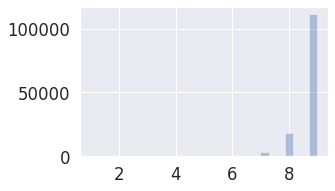

In [34]:
task_name = 'qm9'
tasks = [
   "mu","alpha","homo","lumo","gap","r2","zpve","u0","u298","h298","g298","cv"
]

raw_filename = "data/qm9.csv"
feature_filename = raw_filename.replace('.csv','.pickle')

filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')

smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))

atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []

for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass

print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)

plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

In [35]:
random_seed = 888 
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 500
epochs = 300

p_dropout= 0.5
fingerprint_dim = 280

weight_decay = 4.9 # also known as l2_regularization_lambda
learning_rate = 3.4
radius = 2
T = 2
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [36]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

C
N
O
feature dicts file saved as data/qm9.pickle


,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom,cano_smiles
0,gdb_1,C,157.71180,157.70997,157.70699,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772,C
1,gdb_2,N,293.60975,293.54111,191.39397,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802,N
2,gdb_3,O,799.58812,437.90386,282.94545,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171,O


In [37]:
test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# get the stats of the seen dataset (the training data)
# which will be used to noramlize the dataset. 
columns = ['Task','Mean','Standard deviation', 'Mean absolute deviation','ratio']
mean_list=[]
std_list=[]
mad_list=[]
ratio_list=[]

for task in tasks:
    mean = training_data[task].mean()
    mean_list.append(mean)
    std = training_data[task].std()
    std_list.append(std)
    mad = training_data[task].mad()
    mad_list.append(mad)
    ratio_list.append(std/mad)
    training_data[task+'_normalized'] = (training_data[task]- mean)/std
    test_df[task+'_normalized'] = (test_df[task]- mean)/std

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

list_of_tuples = list(zip(tasks, mean_list, std_list, mad_list, ratio_list))
stats  = pd.DataFrame(list_of_tuples, columns = columns)
stats

,Task,Mean,Standard deviation,Mean absolute deviation,ratio
0,mu,2.705515,1.531188,1.189853,1.286872
1,alpha,75.185527,8.180522,6.300819,1.298327
2,homo,-0.239966,0.022120,0.016288,1.358023
3,lumo,0.011126,0.046951,0.038650,1.214753
4,gap,0.251092,0.047534,0.039677,1.198034
5,r2,1188.891197,278.813211,201.628922,1.382804
6,zpve,0.148492,0.033272,0.026457,1.257577
7,u0,-411.514595,40.046114,31.089048,1.288110
8,u298,-411.506127,40.045897,31.088914,1.288109
9,h298,-411.505182,40.045897,31.088914,1.288109


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


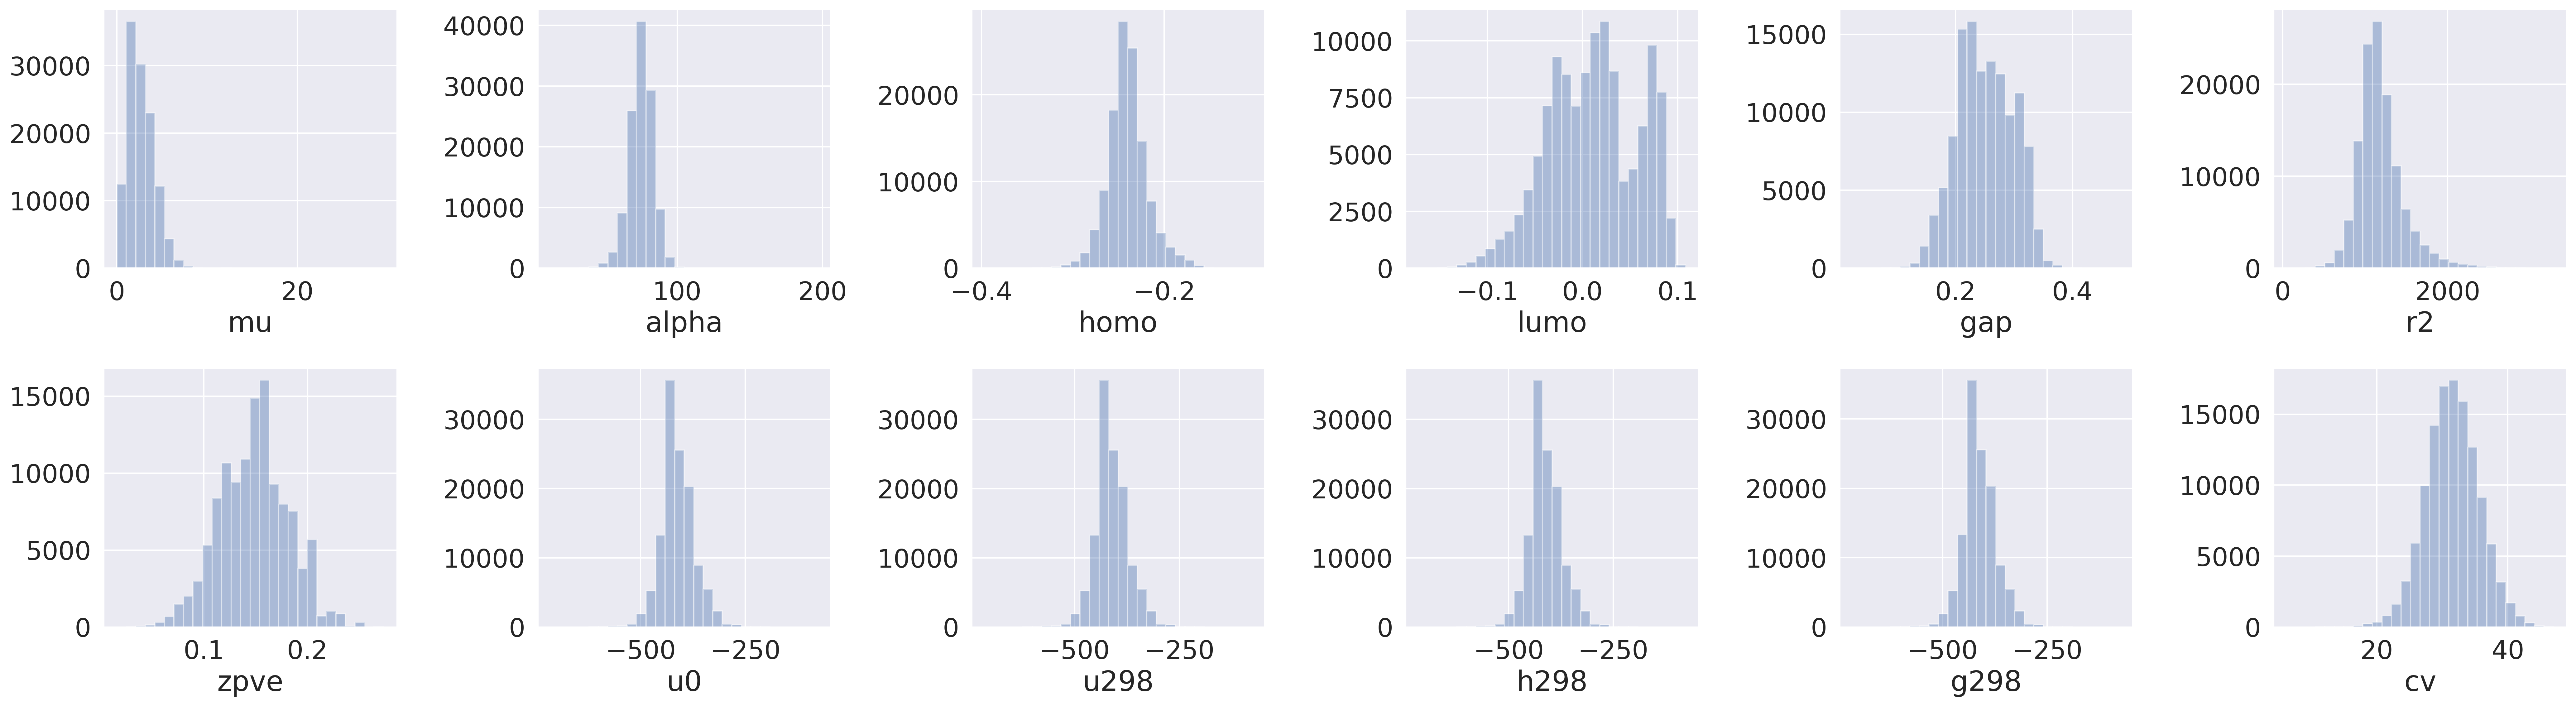

In [40]:
import matplotlib.gridspec as gridspec

# check the value distribution of different tasks
plt.figure(figsize=(28, 8),dpi=300)
gs = gridspec.GridSpec(2, 6)
sns.set(font_scale=1.8)

for i, task in enumerate(tasks):
    plt.subplot(gs[(i)])
    x = pd.Series(training_data[task].values, name=task)
    ax = sns.distplot(x, bins=28, kde=False)
    plt.tight_layout()

plt.show()
plt.close()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


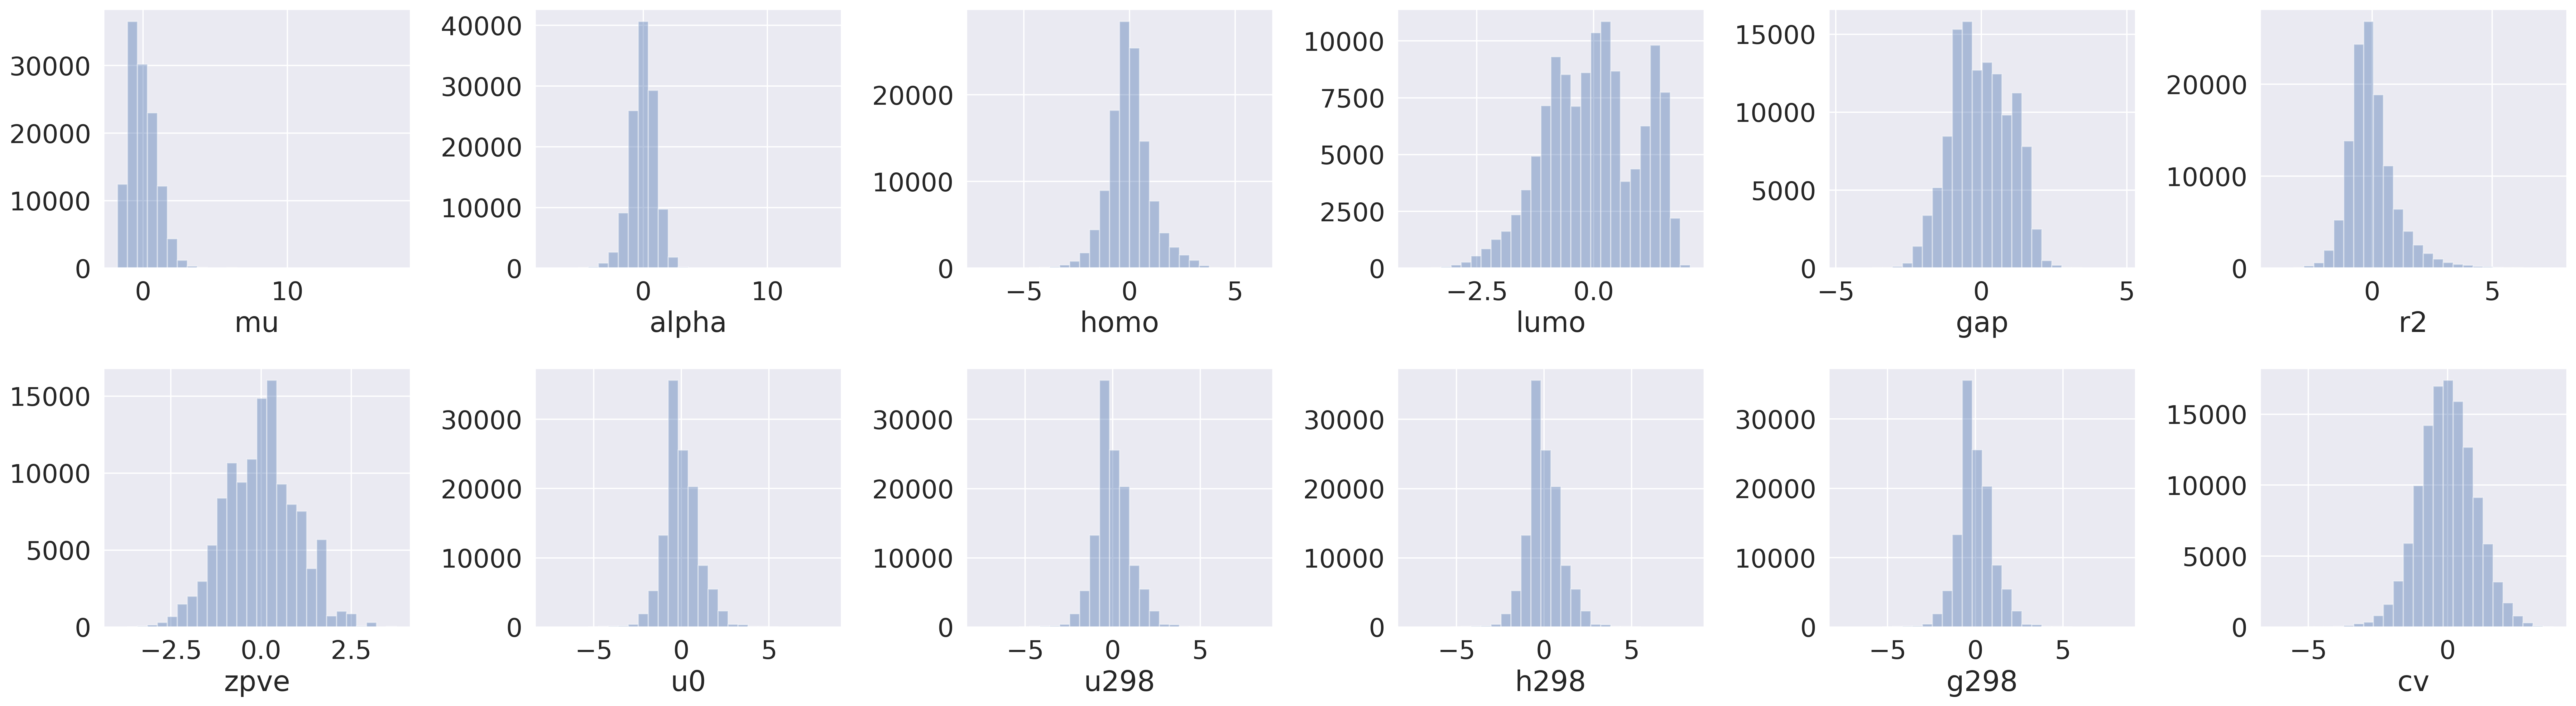

In [41]:
# check the distribution after normalization (should be the same)
plt.figure(figsize=(28, 8),dpi=300)
gs = gridspec.GridSpec(2, 6)
sns.set(font_scale=1.8)

for i, task in enumerate(tasks):
    plt.subplot(gs[(i)])
    x = pd.Series(training_data[task+"_normalized"].values, name=task)
    ax = sns.distplot(x, bins=28, kde=False)
    plt.tight_layout()

plt.show()
plt.close()

In [42]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[8]],feature_dicts)

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

# loss_function = nn.L1Loss()

loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

1682535
atom_fc.weight torch.Size([280, 39])
atom_fc.bias torch.Size([280])
neighbor_fc.weight torch.Size([280, 49])
neighbor_fc.bias torch.Size([280])
GRUCell.0.weight_ih torch.Size([840, 280])
GRUCell.0.weight_hh torch.Size([840, 280])
GRUCell.0.bias_ih torch.Size([840])
GRUCell.0.bias_hh torch.Size([840])
GRUCell.1.weight_ih torch.Size([840, 280])
GRUCell.1.weight_hh torch.Size([840, 280])
GRUCell.1.bias_ih torch.Size([840])
GRUCell.1.bias_hh torch.Size([840])
align.0.weight torch.Size([1, 560])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 560])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([280, 280])
attend.0.bias torch.Size([280])
attend.1.weight torch.Size([280, 280])
attend.1.bias torch.Size([280])
mol_GRUCell.weight_ih torch.Size([840, 280])
mol_GRUCell.weight_hh torch.Size([840, 280])
mol_GRUCell.bias_ih torch.Size([840])
mol_GRUCell.bias_hh torch.Size([840])
mol_align.weight torch.Size([1, 560])
mol_align.bias torch.Size([1])
mol_attend.weight torch.S

In [43]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)
        
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))

        optimizer.zero_grad()
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i]
            y_val = batch_df[task+"_normalized"].values
            loss += loss_function(y_pred, torch.Tensor(y_val).squeeze())*ratio_list[i]**2
        loss.backward()
        optimizer.step()
        
def eval(model, dataset):
    model.eval()
    eval_MAE_list = {}
    eval_MSE_list = {}
    y_val_list = {}
    y_pred_list = {}
    for i,task in enumerate(tasks):
        y_pred_list[task] = np.array([])
        y_val_list[task] = np.array([])
        eval_MAE_list[task] = np.array([])
        eval_MSE_list[task] = np.array([])
        
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
            
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i]
            y_val = batch_df[task+"_normalized"].values
            
            MAE = F.l1_loss(y_pred, torch.Tensor(y_val).squeeze(), reduction='none')        
            MSE = F.mse_loss(y_pred, torch.Tensor(y_val).squeeze(), reduction='none')
            y_pred_list[task] = np.concatenate([y_pred_list[task], y_pred.cpu().detach().numpy()])
            y_val_list[task] = np.concatenate([y_val_list[task], y_val])
            eval_MAE_list[task] = np.concatenate([eval_MAE_list[task],MAE.data.squeeze().cpu().numpy()])
            eval_MSE_list[task] = np.concatenate([eval_MSE_list[task],MSE.data.squeeze().cpu().numpy()])
#     r2_score_list = [r2_score(y_val_list[task], y_pred_list[task]) for task in tasks]
    eval_MAE_normalized = np.array([eval_MAE_list[task].mean() for i, task in enumerate(tasks)])
    eval_MAE = np.multiply(eval_MAE_normalized,np.array(std_list))
    eval_MSE_normalized = np.array([eval_MSE_list[task].mean() for i, task in enumerate(tasks)])
    eval_MSE = np.multiply(eval_MSE_normalized,np.array(std_list))

    return eval_MAE_normalized, eval_MAE, eval_MSE_normalized, eval_MSE #, r2_score_list

In [ ]:
best_param ={}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE_normalized"] = 9e8
best_param["valid_MSE_normalized"] = 9e8

for epoch in range(300):
    train(model, train_df, optimizer, loss_function)
    train_MAE_normalized, train_MAE, train_MSE_normalized, train_MSE = eval(model, train_df)
    valid_MAE_normalized, valid_MAE, valid_MSE_normalized, valid_MSE, = eval(model, valid_df)
    print("EPOCH:\t"+str(epoch)+'\n'\
#         +"train_MAE_normalized: "+str(train_MAE_normalized)+'\n'\
#         +"valid_MAE_normalized: "+str(valid_MAE_normalized)+'\n'\
        +"train_MAE"+":"+"\n"+str(train_MAE)+'\n'\
        +"valid_MAE"+":"+"\n"+str(valid_MAE)+'\n'\
          
        +"train_MSE_normalized_mean: "+str(train_MSE_normalized.mean())+'\n'\
        +"valid_MSE_normalized_mean: "+str(valid_MSE_normalized.mean())+'\n'\
#         +"train_MSE_normalized: "+str(train_MSE_normalized)+'\n'\
#         +"valid_MSE_normalized: "+str(valid_MSE_normalized)+'\n'\
        )
    if train_MSE_normalized.mean() < best_param["train_MSE_normalized"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE_normalized"] = train_MSE_normalized.mean()
    if valid_MSE_normalized.mean() < best_param["valid_MSE_normalized"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE_normalized"] = valid_MSE_normalized.mean()
        if valid_MSE_normalized.mean() < 0.06:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break

mu, alpha, homo, lumo, gap, r2, zpve, u0, u298, h298, g298, cv

In [45]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

test_MAE_normalized, test_MAE, test_MSE_normalized, test_MSE, = eval(best_model, test_df)
print("best epoch:"+str(best_param["valid_epoch"])+'\n'\
    +"test_MAE"+":"+"\n"+str(test_MAE)+'\n'\
    +"test_MSE_normalized_mean: "+str(test_MSE_normalized.mean())+'\n'\
    )

best epoch:116
test_MAE:
[4.75916292e-01 6.04439645e-01 4.03980238e-03 4.41863356e-03
 5.94495643e-03 3.01557362e+01 1.17257423e-03 9.92735521e-01
 9.92692218e-01 9.92692257e-01 9.92827964e-01 2.73997678e-01]
test_MSE_normalized_mean: 0.032973343619372465

